In [1]:
!pip install -U finance-datareader

In [2]:
!pip install yfinance

In [3]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29088 sha256=fcc9c8a2717fafc3831b8803c16a9abe02fcd5b9a3b6b563e0207e598992e379
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [4]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.6 MB/s eta 0:00:00


In [5]:
!pip3 install torch

In [259]:
import numpy as np
import pandas as pd
import random
import os
import re
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import pywt
from google.colab import drive
import warnings
warnings.filterwarnings("ignore")
import FinanceDataReader as fdr
from pandas_datareader import data as pdr
import yfinance as yf
import ta
import time
import sys

from sklearn import linear_model as lm
import xgboost as xgb
import sklearn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.robust import mad
import pmdarima as pm
from pmdarima.arima import ndiffs

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils import weight_norm
from torch.autograd import Variable

In [260]:
#print('python version: ', sys.version)
#print('python interpreter: ', sys.executable)
#print('operating system: ', sys.platform)

python version:  3.10.6 (main, May 29 2023, 11:10:38) [GCC 11.3.0]
python interpreter:  /usr/bin/python3
operating system:  linux


In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

SEED = 42
seed_everything(SEED) # Seed 고정

In [8]:
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
data_dir = '/content/drive/MyDrive/open (2)/'
train = pd.read_csv(data_dir + 'past_open/train.csv')
train_additional = pd.read_csv(data_dir + 'train_additional.csv')
#train = pd.read_parquet(data_dir + 'full_train.parquet')
sample_submission = pd.read_csv(data_dir + 'past_open/sample_submission.csv')

In [ ]:
train.head(), train.shape

(       Date item_Code item_Name  Volume   Open   High    Low  Close  Date_ym  \
 0  20210601   A000020      동화약품  114966  14700  14700  14450  14600   202106   
 1  20210602   A000020      동화약품  109559  14700  14700  14450  14500   202106   
 2  20210603   A000020      동화약품   96158  14550  14650  14450  14600   202106   
 3  20210604   A000020      동화약품  133900  14600  14800  14550  14700   202106   
 4  20210607   A000020      동화약품  511140  14800  15550  14750  15150   202106   
 
    Close_usd_krw  ...         SR         WR   AO          KAMA  ROC       PPO  \
 0    1106.979980  ...  60.000000 -40.000000  0.0  14600.000000  0.0  0.000000   
 1    1107.209961  ...  20.000000 -80.000000  0.0  14599.583767  0.0 -0.054666   
 2    1109.880005  ...  60.000000 -40.000000  0.0  14599.585499  0.0 -0.042205   
 3    1115.439941  ...  71.428571 -28.571429  0.0  14600.003458  0.0  0.022689   
 4    1109.680054  ...  63.636364 -36.363636  0.0  14602.292725  0.0  0.318224   
 
          PVO  Dai

In [ ]:
sample_submission, sample_submission.shape

(         종목코드    순위
 0     A000020     1
 1     A000040     2
 2     A000050     3
 3     A000070     4
 4     A000080     5
 ...       ...   ...
 1995  A375500  1996
 1996  A378850  1997
 1997  A383220  1998
 1998  A383310  1999
 1999  A383800  2000
 
 [2000 rows x 2 columns],
 (2000, 2))

- 전체 2000주 중 상위 200주와 하위 200주를 선정하여 매일 동일 금액 비중으로 거래를 진행한다고 가정
- 상위 200주에 대해서는 매수 전략(Long)을 취하고, 하위 200주에 대해서는 공매도 전략(Short Selling)을 취함
- 거래기간 중 매일 종가에 매수와 공매도가 이루어진다고 가정
  - 매수를 통해 보유한 주식은 다음날 종가에 판매한다고 가정
  - 공매도의 상환 역시 다음날 종가에 이루어진다고 가정
- 결론적으로 참가자들은 거래기간 동안 매일 Long-Short을 반복한다고 가정

public)
- Public 기간 중 예측시점은 2023/5/30
- 참가자들은 예측시점으로부터 향후 15일의 주식 거래일 동안 포트폴리오에 따라 주식거래를 진행
- 해당 기간은 2023/5/31부터 2023/6/21이며, 주식거래가 이뤄지지 않는 날은 제외 (6/6)

private)
- Private 기간 전 예측시점은 2023/7/28, 즉 대회 종료시점
- 참가자들은 예측시점으로부터 향후 15일 주식 거래일 동안 포트폴리오에 따라 주식거래를 진행
- 해당 기간은 2023/7/31부터 2023/8/21이며, 주식거래가 이뤄지지 않는 날은 제외 (8/15)

Private 리더보드는 8/3일부터 공개되기 시작하며, 8/21일의 샤프 지수로 최종 순위가 결정됨 (이는 수식상 n이 1과 2일때 샤프 지수가 계산되지 않기 때문)

액면분할, 액면병합에 따른 주가의 변동도 고려대상에 포함

In [ ]:
train.columns

Index(['일자', '종목코드', '종목명', '거래량', '시가', '고가', '저가', '종가'], dtype='object')

In [ ]:
train = pd.concat([train, train_additional], axis = 0)

In [ ]:
train

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050
...,...,...,...,...,...,...,...,...
83995,20230728,A001080,만호제강,12964,35550,36000,34700,36000
83996,20230728,A104700,한국철강,72644,5780,6030,5780,6030
83997,20230728,A045100,한양이엔지,59562,16230,16390,15970,16330
83998,20230728,A000020,동화약품,86169,9870,10080,9700,9800


In [ ]:
train = train.sort_values(by = ['종목코드', '일자'])
train = train.reset_index(drop = True)
rename_dict = {
    train.columns[0] : 'Date',
    train.columns[1] : 'item_Code',
    train.columns[2] : 'item_Name',
    train.columns[3] : 'Volume',
    train.columns[4] : 'Open',
    train.columns[5] : 'High',
    train.columns[6] : 'Low',
    train.columns[-1] : 'Close'
}
train.rename(columns = rename_dict, inplace = True)
train['Date'] = train['Date'].astype(int)
train['Date_ym'] = train['Date'].astype(str).str[:-2].astype(int)

In [ ]:
for item_Code in train['item_Code'].unique().tolist():
  temp = train[train['item_Code'] == item_Code]
  sum_of_temp = temp[['Volume', 'Open', 'High', 'Low']].sum()
  if sum_of_temp.sum() == 0:
    print(item_Code)

A006580
A012600
A015540
A033340
A065560
A069110
A078590
A099520
A109070
A160600
A178780
A257370
A263540


In [ ]:
code = '006580'
url = f"http://finance.naver.com/item/sise_day.nhn?code={code}"
print(url)

http://finance.naver.com/item/sise_day.nhn?code=006580


In [ ]:
train[train['item_Code'] == 'A006580'].head()

,Date,item_Code,item_Name,Volume,Open,High,Low,Close,Date_ym
146328,20210601,A006580,대양제지,0,0,0,0,3260,202106
146329,20210602,A006580,대양제지,0,0,0,0,3260,202106
146330,20210603,A006580,대양제지,0,0,0,0,3260,202106
146331,20210604,A006580,대양제지,0,0,0,0,3260,202106
146332,20210607,A006580,대양제지,0,0,0,0,3260,202106


In [ ]:
train['Change'] = train.groupby('item_Code')['Close'].pct_change() # 변동성 구하기
train

,Date,item_Code,item_Name,Volume,Open,High,Low,Close,Date_ym,Change
0,20210601,A000020,동화약품,114966,14700,14700,14450,14600,202106,NaN
1,20210602,A000020,동화약품,109559,14700,14700,14450,14500,202106,-0.006849
2,20210603,A000020,동화약품,96158,14550,14650,14450,14600,202106,0.006897
3,20210604,A000020,동화약품,133900,14600,14800,14550,14700,202106,0.006849
4,20210607,A000020,동화약품,511140,14800,15550,14750,15150,202106,0.030612
...,...,...,...,...,...,...,...,...,...,...
1071995,20230724,A383800,LX홀딩스,232782,7850,8000,7710,7800,202307,-0.007634
1071996,20230725,A383800,LX홀딩스,3965325,7850,8960,7700,8140,202307,0.043590
1071997,20230726,A383800,LX홀딩스,2042248,8150,8850,7780,7980,202307,-0.019656
1071998,20230727,A383800,LX홀딩스,538081,8050,8430,7910,8220,202307,0.030075


In [ ]:
train[train['item_Code'] == 'A006580']

,Date,item_Code,item_Name,Volume,Open,High,Low,Close,Date_ym,Change
146328,20210601,A006580,대양제지,0,0,0,0,3260,202106,NaN
146329,20210602,A006580,대양제지,0,0,0,0,3260,202106,0.0
146330,20210603,A006580,대양제지,0,0,0,0,3260,202106,0.0
146331,20210604,A006580,대양제지,0,0,0,0,3260,202106,0.0
146332,20210607,A006580,대양제지,0,0,0,0,3260,202106,0.0
...,...,...,...,...,...,...,...,...,...,...
146859,20230724,A006580,대양제지,0,0,0,0,3260,202307,0.0
146860,20230725,A006580,대양제지,0,0,0,0,3260,202307,0.0
146861,20230726,A006580,대양제지,0,0,0,0,3260,202307,0.0
146862,20230727,A006580,대양제지,0,0,0,0,3260,202307,0.0


In [ ]:
def read_dataset(dataset_dir, is_display = True, ignore_index = False):
  dataset_name = dataset_dir.split('/')[-1]
  print('dataset: ', dataset_name)
  try:
    if ignore_index == True:
      save_dataset = pd.read_csv(f'{dataset_dir}', index_col = 0)
    else:
      save_dataset = pd.read_csv(f'{dataset_dir}')
  except:
    if ignore_index == True:
      save_dataset = pd.read_csv(f'{dataset_dir}', encoding = 'CP949', index_col = 0)
    else:
      save_dataset = pd.read_csv(f'{dataset_dir}', encoding = 'CP949')
  if is_display == True:
    display(save_dataset)
  return save_dataset

**상관 자산**

경기종합지수 (2021.06 ~ 2023.05 : 월단위)
- 선행종합지수: 가까운 장래의 경기 흐름을 가늠하는 지표로 지수가 전월보다 올라가면 경기 상승, 내려가면 경기 하강을 의미
- 동행종합지수: 현재의 경기 상태를 나타내는 지표
- 후행종합지수: 경기의 변동을 사후에 확인하는 지표
- 순환변동치: 경기지수를 산출하는데 있어 계절, 천재지변, 경제성장에 따른 추세적 요인을 제외한 순수한 경기지수의 변동치
- 경제심리지수

https://velog.io/@chaliechu117/KOSIS%EA%B5%AD%EA%B0%80%ED%86%B5%EA%B3%84%ED%8F%AC%ED%84%B8-%EA%B2%BD%EA%B8%B0%EC%A2%85%ED%95%A9%EC%A7%80%EC%88%98-%EC%8B%9C%EA%B3%84%EC%97%B4-%EB%8D%B0%EC%9D%B4%ED%84%B0-%EB%B6%84%EC%84%9D

https://sgsg.hankyung.com/article/2022070851821

https://kosis.kr/statHtml/statHtml.do?orgId=301&tblId=DT_513Y001&vw_cd=MT_ZTITLE&list_id=J1_301025&scrId=&seqNo=&lang_mode=ko&obj_var_id=&itm_id=&conn_path=MT_ZTITLE&path=%252FstatisticsList%252FstatisticsListIndex.do

In [ ]:
composite_index = read_dataset(data_dir + '경기종합지수_2020100__10차__20230711222648.csv', is_display = False, ignore_index = True) # 경기 종합 지수
composite_index = composite_index.T
composite_index.reset_index(inplace = True)
composite_index.rename(columns = {'index':'Date_ym'}, inplace = True)
composite_index['Date_ym'] = composite_index['Date_ym'].str.replace(pat = r'[.p)]', repl = r'', regex = True).astype(int)
composite_index.columns = composite_index.columns.str.replace('[()〔〕p%2020=100 ]', '')
composite_index.columns = ['Date_ym', '선행종합지수', '선행종합지수전월비', '재고순환지표전월차', '경제심리지수전월차',
       '기계류내수출하지수선박제외전월비', '건설수주액전월비', '수출입물가비율전월비', '코스피전월비', '장단기금리차전월차',
       '선행지수순환변동치', '선행지수순환변동치전월차', '선행지수전년동월비', '전년동월비전월차', '동행종합지수', '동행종합지수전월비',
       '광공업생산지수전월비', '서비스업생산지수도소매업제외전월비', '건설기성액전월비', '소매판매액지수전월비',
       '내수출하지수전월비', '수입액전월비', '비농림어업취업자수전월비', '동행지수순환변동치', '동행지수순환변동치전월차',
       '후행종합지수', '후행종합지수전월비', '생산자제품재고지수전월비', '소비자물가지수변화율서비스전월차', '소비재수입액전월비',
       '취업자수전월비', 'CP유통수익률전월차']

dataset:  경기종합지수_2020100__10차__20230711222648.csv


In [ ]:
train = train.merge(composite_index, on = 'Date_ym', how = 'left')
train.drop(['Date_ym'], axis = 1, inplace = True)

FRED (2021 06.01 ~ 2023 05.30)
- 나스닥 지수
- 주간 실업수당 청구 건수(ICSA)
- 미시건대 소비자심리지수(UMCSENT)
- 주택판매지수(HSN1F)
- M2통화량(M2)
- 하이일드 채권 스프레드

https://tariat.tistory.com/1252

https://coding-kindergarten.tistory.com/125

https://www.facebook.com/groups/pythonkorea/posts/3370820856334385/

https://psystat.tistory.com/164

https://fred.stlouisfed.org/

In [ ]:
nasdaq_index = read_dataset(data_dir + 'NASDAQCOM.csv', is_display = False, ignore_index = False) # 나스닥 종합 지수
nasdaq_index['Date'] = nasdaq_index['DATE'].str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)
nasdaq_index.drop(['DATE'], axis = 1, inplace = True)
train = train.merge(nasdaq_index, on = 'Date', how = 'left')
train

dataset:  NASDAQCOM.csv


,Date,item_Code,item_Name,Volume,Open,High,Low,Close,Change,선행종합지수,...,동행지수순환변동치,동행지수순환변동치전월차,후행종합지수,후행종합지수전월비,생산자제품재고지수전월비,소비자물가지수변화율서비스전월차,소비재수입액전월비,취업자수전월비,CP유통수익률전월차,NASDAQCOM
0,20210601,A000020,동화약품,114966,14700,14700,14450,14600,NaN,106.9,...,99.2,-0.1,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13736.48
1,20210602,A000020,동화약품,109559,14700,14700,14450,14500,-0.006849,106.9,...,99.2,-0.1,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13756.33
2,20210603,A000020,동화약품,96158,14550,14650,14450,14600,0.006897,106.9,...,99.2,-0.1,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13614.51
3,20210604,A000020,동화약품,133900,14600,14800,14550,14700,0.006849,106.9,...,99.2,-0.1,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13814.49
4,20210607,A000020,동화약품,511140,14800,15550,14750,15150,0.030612,106.9,...,99.2,-0.1,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13881.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987995,20230523,A383800,LX홀딩스,150364,8390,8390,8310,8330,-0.003589,109.7,...,99.9,0.1,113.7,0.3,1.8,0.0,-2.1,0.2,-0.1,12560.25
987996,20230524,A383800,LX홀딩스,122457,8310,8340,8280,8300,-0.003601,109.7,...,99.9,0.1,113.7,0.3,1.8,0.0,-2.1,0.2,-0.1,12484.16
987997,20230525,A383800,LX홀딩스,84241,8300,8310,8270,8310,0.001205,109.7,...,99.9,0.1,113.7,0.3,1.8,0.0,-2.1,0.2,-0.1,12698.09
987998,20230526,A383800,LX홀딩스,126681,8300,8310,8270,8280,-0.003610,109.7,...,99.9,0.1,113.7,0.3,1.8,0.0,-2.1,0.2,-0.1,12975.69


In [ ]:
# icsa = read_dataset('/content/ICSA.csv', is_display = False, ignore_index = False) # 주간 실업수당 청구 건수 (ICSA)
# icsa['Date'] = icsa['DATE'].str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)
# icsa.drop(['DATE'], axis = 1, inplace = True)
# train = train.merge(icsa, on = 'Date', how = 'left')
# train

In [ ]:
# umcsent = read_dataset('/content/UMCSENT.csv', is_display = False, ignore_index = False) # 미시건대 소비자심리지수(UMCSENT)
# umcsent['Date'] = umcsent['DATE'].str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)
# umcsent.drop(['DATE'], axis = 1, inplace = True)
# train = train.merge(umcsent, on = 'Date', how = 'left')
# train

In [ ]:
# hsn1f = read_dataset('/content/HSN1F.csv', is_display = False, ignore_index = False) # 주택판매지수(HSN1F)
# hsn1f['Date'] = hsn1f['DATE'].str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)
# hsn1f.drop(['DATE'], axis = 1, inplace = True)
# train = train.merge(hsn1f, on = 'Date', how = 'left')
# train

In [ ]:
m2 = read_dataset(data_dir + 'BAMLH0A0HYM2EY.csv', is_display = False, ignore_index = False) # M2통화량(M2)
m2['Date'] = m2['DATE'].str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)
m2.drop(['DATE'], axis = 1, inplace = True)
train = train.merge(m2, on = 'Date', how = 'left')
train

dataset:  BAMLH0A0HYM2EY.csv


,Date,item_Code,item_Name,Volume,Open,High,Low,Close,Change,선행종합지수,...,동행지수순환변동치전월차,후행종합지수,후행종합지수전월비,생산자제품재고지수전월비,소비자물가지수변화율서비스전월차,소비재수입액전월비,취업자수전월비,CP유통수익률전월차,NASDAQCOM,BAMLH0A0HYM2EY
0,20210601,A000020,동화약품,114966,14700,14700,14450,14600,NaN,106.9,...,-0.1,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13736.48,4.29
1,20210602,A000020,동화약품,109559,14700,14700,14450,14500,-0.006849,106.9,...,-0.1,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13756.33,4.26
2,20210603,A000020,동화약품,96158,14550,14650,14450,14600,0.006897,106.9,...,-0.1,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13614.51,4.26
3,20210604,A000020,동화약품,133900,14600,14800,14550,14700,0.006849,106.9,...,-0.1,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13814.49,4.21
4,20210607,A000020,동화약품,511140,14800,15550,14750,15150,0.030612,106.9,...,-0.1,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13881.72,4.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987995,20230523,A383800,LX홀딩스,150364,8390,8390,8310,8330,-0.003589,109.7,...,0.1,113.7,0.3,1.8,0.0,-2.1,0.2,-0.1,12560.25,8.52
987996,20230524,A383800,LX홀딩스,122457,8310,8340,8280,8300,-0.003601,109.7,...,0.1,113.7,0.3,1.8,0.0,-2.1,0.2,-0.1,12484.16,8.66
987997,20230525,A383800,LX홀딩스,84241,8300,8310,8270,8310,0.001205,109.7,...,0.1,113.7,0.3,1.8,0.0,-2.1,0.2,-0.1,12698.09,8.68
987998,20230526,A383800,LX홀딩스,126681,8300,8310,8270,8280,-0.003610,109.7,...,0.1,113.7,0.3,1.8,0.0,-2.1,0.2,-0.1,12975.69,8.67


In [ ]:
highyeild = read_dataset(data_dir + 'WM2NS.csv', is_display = False, ignore_index = False) # 하이일드 채권 스프레드
highyeild['Date'] = highyeild['DATE'].str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)
highyeild.drop(['DATE'], axis = 1, inplace = True)
train = train.merge(highyeild, on = 'Date', how = 'left')
train

dataset:  WM2NS.csv


,Date,item_Code,item_Name,Volume,Open,High,Low,Close,Change,선행종합지수,...,후행종합지수,후행종합지수전월비,생산자제품재고지수전월비,소비자물가지수변화율서비스전월차,소비재수입액전월비,취업자수전월비,CP유통수익률전월차,NASDAQCOM,BAMLH0A0HYM2EY,WM2NS
0,20210601,A000020,동화약품,114966,14700,14700,14450,14600,NaN,106.9,...,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13736.48,4.29,NaN
1,20210602,A000020,동화약품,109559,14700,14700,14450,14500,-0.006849,106.9,...,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13756.33,4.26,NaN
2,20210603,A000020,동화약품,96158,14550,14650,14450,14600,0.006897,106.9,...,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13614.51,4.26,NaN
3,20210604,A000020,동화약품,133900,14600,14800,14550,14700,0.006849,106.9,...,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13814.49,4.21,NaN
4,20210607,A000020,동화약품,511140,14800,15550,14750,15150,0.030612,106.9,...,103.4,0.2,-0.5,0.1,0.0,0.2,0.0,13881.72,4.20,20418.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987995,20230523,A383800,LX홀딩스,150364,8390,8390,8310,8330,-0.003589,109.7,...,113.7,0.3,1.8,0.0,-2.1,0.2,-0.1,12560.25,8.52,NaN
987996,20230524,A383800,LX홀딩스,122457,8310,8340,8280,8300,-0.003601,109.7,...,113.7,0.3,1.8,0.0,-2.1,0.2,-0.1,12484.16,8.66,NaN
987997,20230525,A383800,LX홀딩스,84241,8300,8310,8270,8310,0.001205,109.7,...,113.7,0.3,1.8,0.0,-2.1,0.2,-0.1,12698.09,8.68,NaN
987998,20230526,A383800,LX홀딩스,126681,8300,8310,8270,8280,-0.003610,109.7,...,113.7,0.3,1.8,0.0,-2.1,0.2,-0.1,12975.69,8.67,NaN


환율 데이터 (2021 06.01 ~ 2023 05.30)

- USD/KRW
- USD/EUR
- USD/JPY
- USD/RUB
- KOSPI
- KOSDAQ
- DJI
- IXIC
- S&P500

In [ ]:
usd_krw = fdr.DataReader('USD/KRW', start = '2021-06-01', end = '2023-07-28') # USD/KRW
usd_krw.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)
usd_krw = usd_krw.add_suffix('_usd_krw')
usd_krw = usd_krw.reset_index()
usd_krw['Date'] = usd_krw['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

usd_eur = fdr.DataReader('USD/EUR', start = '2021-06-01', end = '2023-07-28') # USD/EUR
usd_eur.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)
usd_eur = usd_eur.add_suffix('_usd_eur')
usd_eur = usd_eur.reset_index()
usd_eur['Date'] = usd_eur['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

usd_jpy = fdr.DataReader('USD/JPY', start = '2021-06-01', end = '2023-07-28') # USD/JPY
usd_jpy.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)
usd_jpy = usd_jpy.add_suffix('_usd_jpy')
usd_jpy = usd_jpy.reset_index()
usd_jpy['Date'] = usd_jpy['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

usd_rub = fdr.DataReader('USD/RUB', start = '2021-06-01', end = '2023-07-28') # USD/RUB
usd_rub.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)
usd_rub = usd_rub.add_suffix('_usd_rub')
usd_rub = usd_rub.reset_index()
usd_rub['Date'] = usd_rub['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

kospi = fdr.DataReader('KS11', start = '2021-06-01', end = '2023-07-28') # kospi
kospi.drop(['Open', 'High', 'Low', 'Adj Close'], axis = 1, inplace = True)
kospi = kospi.add_suffix('_kospi')
kospi = kospi.reset_index()
kospi['Date'] = kospi['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

kosdaq = fdr.DataReader('KQ11', start = '2021-06-01', end = '2023-07-28') # kosdaq
kosdaq.drop(['Open', 'High', 'Low', 'Adj Close'], axis = 1, inplace = True)
kosdaq = kosdaq.add_suffix('_kosdaq')
kosdaq = kosdaq.reset_index()
kosdaq['Date'] = kosdaq['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

dji = fdr.DataReader('DJI', start = '2021-06-01', end = '2023-07-29') # dji
dji.drop(['Open', 'High', 'Low', 'Adj Close'], axis = 1, inplace = True)
dji = dji.add_suffix('_dji')
dji = dji.reset_index()
dji['Date'] = dji['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

ixic = fdr.DataReader('IXIC', start = '2021-06-01', end = '2023-07-29') # ixic
ixic.drop(['Open', 'High', 'Low', 'Adj Close'], axis = 1, inplace = True)
ixic = ixic.add_suffix('_ixic')
ixic = ixic.reset_index()
ixic['Date'] = ixic['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

sp500 = fdr.DataReader('S&P500', start = '2021-06-01', end = '2023-07-29') # s&p500
sp500.drop(['Open', 'High', 'Low', 'Adj Close'], axis = 1, inplace = True)
sp500 = sp500.add_suffix('_sp500')
sp500 = sp500.reset_index()
sp500['Date'] = sp500['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

- BTC/KRW
- GOLD

In [ ]:
btc_krw = fdr.DataReader('BTC/KRW', start = '2021-06-01', end = '2023-07-28') # BTC/KRW
btc_krw.drop(['Open', 'High', 'Low', 'Adj Close'], axis = 1, inplace = True)
btc_krw = btc_krw.add_suffix('_btc_krw')
btc_krw = btc_krw.reset_index()
btc_krw['Date'] = btc_krw['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

In [ ]:
yf.pdr_override()
gold = pdr.get_data_yahoo('GC=F', start = '2021-06-01', end = '2023-07-29') # GOLD
gold.drop(['Open', 'High', 'Low', 'Adj Close'], axis = 1, inplace = True)
gold = gold.add_suffix('_gold')
gold = gold.reset_index()
gold['Date'] = gold['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

[*********************100%***********************]  1 of 1 completed


In [ ]:
irx = pdr.get_data_yahoo('^IRX', start = '2021-06-01', end = '2023-07-29') # 미국 국채 금리 13주 국채
irx.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)
irx = irx.add_suffix('_irx')
irx = irx.reset_index()
irx['Date'] = irx['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

fvx = pdr.get_data_yahoo('^FVX', start = '2021-06-01', end = '2023-07-29') # 미국 국채 금리 국채 수익률 5년
fvx.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)
fvx = fvx.add_suffix('_fvx')
fvx = fvx.reset_index()
fvx['Date'] = fvx['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

tnx = pdr.get_data_yahoo('^TNX', start = '2021-06-01', end = '2023-07-29') # 미국 국채 금리 국채 수익률 10년
tnx.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis = 1, inplace = True)
tnx = tnx.add_suffix('_tnx')
tnx = tnx.reset_index()
tnx['Date'] = tnx['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

us_bond = pdr.get_data_yahoo('IEF', start = '2021-06-01', end = '2023-07-29') # 미국 채권 7~10년물
us_bond.drop(['Open', 'High', 'Low'], axis = 1, inplace = True)
us_bond = us_bond.add_suffix('_us_bond')
us_bond = us_bond.reset_index()
us_bond['Date'] = us_bond['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

kr_bond = pdr.get_data_yahoo('148070.KS', start = '2021-06-01', end = '2023-07-29') # 한국 채권 7~10년물
kr_bond.drop(['Open', 'High', 'Low'], axis = 1, inplace = True)
kr_bond = kr_bond.add_suffix('_kr_bond')
kr_bond = kr_bond.reset_index()
kr_bond['Date'] = kr_bond['Date'].astype(str).str.replace(pat = r'[-]', repl = r'', regex = True).astype(int)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
merge_datasets = [usd_krw, usd_eur, usd_jpy, usd_rub, kospi, kosdaq, dji, ixic, sp500, btc_krw, gold, irx, fvx, tnx, us_bond, kr_bond]
for merge_dataset in merge_datasets:
  train = train.merge(merge_dataset, on = 'Date', how = 'left')

In [ ]:
train

,Date,item_Code,item_Name,Volume,Open,High,Low,Close,Date_ym,Close_usd_krw,...,Volume_gold,Close_irx,Close_fvx,Close_tnx,Close_us_bond,Adj Close_us_bond,Volume_us_bond,Close_kr_bond,Adj Close_kr_bond,Volume_kr_bond
0,20210601,A000020,동화약품,114966,14700,14700,14450,14600,202106,1106.979980,...,640.0,0.010,0.809,1.615,114.300003,110.153992,9498100.0,119330.0,118022.039062,13680.0
1,20210602,A000020,동화약품,109559,14700,14700,14450,14500,202106,1107.209961,...,1267.0,0.015,0.796,1.591,114.430000,110.279266,4269900.0,119110.0,117804.453125,10724.0
2,20210603,A000020,동화약품,96158,14550,14650,14450,14600,202106,1109.880005,...,1021.0,0.015,0.845,1.625,114.139999,109.999779,3591200.0,119240.0,117933.023438,48541.0
3,20210604,A000020,동화약품,133900,14600,14800,14550,14700,202106,1115.439941,...,367.0,0.015,0.784,1.560,114.769997,110.606934,6326000.0,119440.0,118130.835938,36730.0
4,20210607,A000020,동화약품,511140,14800,15550,14750,15150,202106,1109.680054,...,87.0,0.018,0.793,1.569,114.680000,110.520195,3068500.0,119655.0,118343.476562,4780.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085995,20230728,A383800,LX홀딩스,223590,8280,8300,8100,8230,202307,1283.880005,...,194253.0,5.255,4.195,3.969,95.620003,95.620003,5794100.0,109725.0,109725.000000,10557.0
1085996,20230728,A383800,LX홀딩스,223590,8280,8300,8100,8230,202307,1272.810059,...,194253.0,5.255,4.195,3.969,95.620003,95.620003,5794100.0,109725.0,109725.000000,10557.0
1085997,20230728,A383800,LX홀딩스,223590,8280,8300,8100,8230,202307,1272.810059,...,194253.0,5.255,4.195,3.969,95.620003,95.620003,5794100.0,109725.0,109725.000000,10557.0
1085998,20230728,A383800,LX홀딩스,223590,8280,8300,8100,8230,202307,1272.810059,...,194253.0,5.255,4.195,3.969,95.620003,95.620003,5794100.0,109725.0,109725.000000,10557.0


https://songseungwon.tistory.com/118

**기술 지표**

In [ ]:
def get_technical_indicators(dataset, item_Code):

  dataset = dataset[dataset['item_Code'] == item_Code]
  O = dataset['Open']
  H = dataset['High']
  L = dataset['Low']
  C = dataset['Close']
  V = dataset['Volume']

  dataset['MFI'] = ta.volume.money_flow_index(high=H, low=L, close=C, volume=V, fillna=True)
  dataset['ADI'] = ta.volume.acc_dist_index(high=H, low=L, close=C, volume=V, fillna=True)
  dataset['OBV'] = ta.volume.on_balance_volume(close=C, volume=V, fillna=True)
  dataset['CMF'] = ta.volume.chaikin_money_flow(high=H, low=L, close=C, volume=V, fillna=True)
  dataset['FI'] = ta.volume.force_index(close=C, volume=V, fillna=True)
  dataset['EOM, EMV'] = ta.volume.ease_of_movement(high=H, low=L, volume=V, fillna=True)
  dataset['VPT'] = ta.volume.volume_price_trend(close=C, volume=V, fillna=True)
  dataset['NVI'] = ta.volume.negative_volume_index(close=C, volume=V, fillna=True)
  dataset['VMAP'] = ta.volume.volume_weighted_average_price(high=H, low=L, close=C, volume=V, fillna=True)

  # Volatility
  dataset['ATR'] = ta.volatility.average_true_range(high=H, low=L, close=C, fillna=True)
  dataset['UB'] = ta.volatility.bollinger_hband(close=C, fillna=True)
  dataset['AB'] = ta.volatility.bollinger_mavg(close=C, fillna=True)
  dataset['LB'] = ta.volatility.bollinger_lband(close=C, fillna=True)
  dataset['KCH'] = ta.volatility.keltner_channel_hband(high=H, low=L, close=C, fillna=True)
  dataset['KCL'] = ta.volatility.keltner_channel_lband(high=H, low=L, close=C, fillna=True)
  dataset['KCM'] = ta.volatility.keltner_channel_mband(high=H, low=L, close=C, fillna=True)
  dataset['DCH'] = ta.volatility.donchian_channel_hband(high=H, low=L, close=C, fillna=True)
  dataset['DCL'] = ta.volatility.donchian_channel_lband(high=H, low=L, close=C, fillna=True)
  dataset['DCM'] = ta.volatility.donchian_channel_mband(high=H, low=L, close=C, fillna=True)
  dataset['UI'] = ta.volatility.ulcer_index(close=C, fillna=True)

  # Trend
  timeperiods = [5, 6, 7, 10, 20, 21, 50, 60, 100, 120]
  for timeperiod in timeperiods:
    dataset[f'MA{timeperiod}'] = C.rolling(window = timeperiod).mean().values

  dataset['SMA'] = ta.trend.sma_indicator(close=C, fillna=True)
  dataset['EMA'] = ta.trend.ema_indicator(close=C, fillna=True)
  dataset['WMA'] = ta.trend.wma_indicator(close=C, fillna=True)
  dataset['MACD'] = ta.trend.macd(close=C, fillna=True)
  dataset['MACD_Signal'] = ta.trend.macd_signal(close=C, fillna=True)
  dataset['ADX'] = ta.trend.adx(high=H, low=L, close=C, fillna=True)
  dataset['-VI'] = ta.trend.vortex_indicator_neg(high=H, low=L, close=C, fillna=True)
  dataset['+VI'] = ta.trend.vortex_indicator_pos(high=H, low=L, close=C, fillna=True)
  dataset['TRIX'] = ta.trend.trix(close=C, fillna=True)
  dataset['MI'] = ta.trend.mass_index(high=H, low=L, fillna=True)
  dataset['CCI'] = ta.trend.cci(high=H, low=L, close=C, fillna=True)
  dataset['DPO'] = ta.trend.dpo(close=C, fillna=True)
  dataset['KST'] = ta.trend.kst(close=C, fillna=True)
  dataset['Ichimoku'] = ta.trend.ichimoku_a(high=H, low=L, fillna=True)
  dataset['Parabolic SAR'] = ta.trend.psar_down(high=H, low=L, close=C, fillna=True)
  dataset['STC'] = ta.trend.stc(close=C, fillna=True)

  # Momentum
  dataset['RSI'] = ta.momentum.rsi(close=C, fillna=True)
  dataset['SRSI'] = ta.momentum.stochrsi(close=C, fillna=True)
  dataset['TSI'] = ta.momentum.tsi(close=C, fillna=True)
  dataset['UO'] = ta.momentum.ultimate_oscillator(high=H, low=L, close=C, fillna=True)
  dataset['SR'] = ta.momentum.stoch(close=C, high=H, low=L, fillna=True)
  dataset['WR'] = ta.momentum.williams_r(high=H, low=L, close=C, fillna=True)
  dataset['AO'] = ta.momentum.awesome_oscillator(high=H, low=L, fillna=True)
  dataset['KAMA'] = ta.momentum.kama(close=C, fillna=True)
  dataset['ROC'] = ta.momentum.roc(close=C, fillna=True)
  dataset['PPO'] = ta.momentum.ppo(close=C, fillna=True)
  dataset['PVO'] = ta.momentum.pvo(volume=V, fillna=True)

  # Momentum
  #dataset['momentum'] = C - 1
  #dataset['log_momentum'] = np.log1p(dataset['momentum'])

  # Calculate Daily_Range and Mean
  dataset['Daily_Range'] = C - O
  dataset['Mean'] = (H + L) / 2

  return dataset

In [ ]:
# def get_technical_indicators(dataset, item_Code):

#   dataset = dataset[dataset['item_Code'] == item_Code]

#   # Moving Average
#   numbers = [5, 7, 10, 20, 21, 50, 100]
#   for number in numbers:
#     dataset[f'ma{number}'] = dataset['Close'].rolling(window = number).mean().values

#   # MACD
#   dataset['ema26'] = dataset['Close'].ewm(span = 26, min_periods = 26-1, adjust = False).mean().values
#   dataset['ema12'] = dataset['Close'].ewm(span = 12, min_periods = 12-1, adjust = False).mean().values
#   dataset['MACD'] = (dataset['ema26'] - dataset['ema12'])
#   dataset['MACD_Signal'] = dataset['MACD'].ewm(span = 9, min_periods = 9-1, adjust = False).mean().values
#   dataset['MACD_Oscillator'] = dataset['MACD'] - dataset['MACD_Signal']

#   # Bollinger Bands
#   dataset['sd20'] = dataset['Close'].rolling(window = 20).std().values
#   dataset['Upper'] = dataset['ma20'] + 2*dataset['sd20']
#   dataset['Lower'] = dataset['ma20'] - 2*dataset['sd20']

#   # Exponential moving average
#   dataset['ema'] = dataset['Close'].ewm(com = 0.5).mean().values

#   # Momentum
#   dataset['momentum'] = dataset['Close'] - 1
#   dataset['log_momentum'] = np.log1p(dataset['momentum'])

#   # RSI
#   dataset['u'] = np.where(dataset['Close'].diff(1) > 0, dataset['Close'].diff(1), 0)
#   dataset['d'] = np.where(dataset['Close'].diff(1) < 0, dataset['Close'].diff(1)*(-1), 0)
#   dataset['au'] = dataset['u'].rolling(window = 14).mean().values
#   dataset['ad'] = dataset['d'].rolling(window = 14).mean().values
#   dataset['rsi'] = dataset['au'] / (dataset['au'] + dataset['ad']) * 100
#   dataset['rsi_Signal'] = dataset['rsi'].rolling(window = 9).mean().values

#   # VWAP
#   dataset['volume_price'] = dataset['Open'] * dataset['Volume']
#   dataset['volume_price_sum'] = dataset['volume_price'].apply(lambda x: np.cumsum(x)).values
#   dataset['volume_sum'] = dataset['Volume'].apply(lambda x: np.cumsum(x)).values
#   dataset['vwap'] = dataset['volume_price_sum'] / dataset['volume_sum']
#   dataset['diff'] = dataset['Open'] - dataset['vwap'] # diff : 양수 - 상승세, 음수 - 하락세

#   # CCI
#   typical_price = (dataset['High'] + dataset['Low'] + dataset['Close']) / 3
#   sma = typical_price.rolling(window = 20).mean()
#   mean_deviation = (typical_price - sma).abs().rolling(window = 20).mean()
#   dataset['cci'] = (typical_price - sma) / (0.015 * mean_deviation)

#   return dataset

In [ ]:
start = time.time()
train_concat = pd.concat([get_technical_indicators(group, item_Code) for item_Code, group in train.groupby('item_Code')], axis=0)

#train_concat = train.groupby('item_Code').apply(get_technical_indicators()).reset_index(drop=True)

print("time :", time.time() - start)

time : 872.290910243988


In [ ]:
train = train_concat.copy()

In [ ]:
train

,Date,item_Code,item_Name,Volume,Open,High,Low,Close,Date_ym,Close_usd_krw,...,UO,SR,WR,AO,KAMA,ROC,PPO,PVO,Daily_Range,Mean
0,20210601,A000020,동화약품,114966,14700,14700,14450,14600,202106,1106.979980,...,0.000000,60.000000,-40.000000,0.000000,14600.000000,0.000000,0.000000,0.000000,-100,14575.0
1,20210602,A000020,동화약품,109559,14700,14700,14450,14500,202106,1107.209961,...,10.000000,20.000000,-80.000000,0.000000,14599.583767,0.000000,-0.054666,-0.376490,-200,14575.0
2,20210603,A000020,동화약품,96158,14550,14650,14450,14600,202106,1109.880005,...,28.571429,60.000000,-40.000000,0.000000,14599.585499,0.000000,-0.042205,-1.619559,50,14550.0
3,20210604,A000020,동화약품,133900,14600,14800,14550,14700,202106,1115.439941,...,36.842105,71.428571,-28.571429,0.000000,14600.003458,0.000000,0.022689,0.086992,100,14675.0
4,20210607,A000020,동화약품,511140,14800,15550,14750,15150,202106,1109.680054,...,44.444444,63.636364,-36.363636,0.000000,14602.292725,0.000000,0.318224,22.003352,350,15150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1085995,20230728,A383800,LX홀딩스,223590,8280,8300,8100,8230,202307,1283.880005,...,39.848466,42.063492,-57.936508,174.000000,8790.814142,2.746567,0.559356,24.971855,-50,8200.0
1085996,20230728,A383800,LX홀딩스,223590,8280,8300,8100,8230,202307,1272.810059,...,42.440047,42.063492,-57.936508,180.147059,8788.479848,2.875000,0.641832,17.905772,-50,8200.0
1085997,20230728,A383800,LX홀딩스,223590,8280,8300,8100,8230,202307,1272.810059,...,53.296674,42.063492,-57.936508,181.029412,8786.155270,4.177215,0.698807,11.845397,-50,8200.0
1085998,20230728,A383800,LX홀딩스,223590,8280,8300,8100,8230,202307,1272.810059,...,54.947476,42.063492,-57.936508,181.176471,8783.840367,4.574333,0.735223,6.682143,-50,8200.0


In [ ]:
train.shape

(1086000, 95)

In [ ]:
train.isin([np.nan]).sum()[train.isin([np.nan]).sum() > 0]

Close_kospi            4000
Volume_kospi           4000
Close_kosdaq           6000
Volume_kosdaq          6000
Close_dji             38000
Volume_dji            38000
Close_ixic            38000
Volume_ixic           38000
Close_sp500           38000
Volume_sp500          38000
Close_gold            38000
Volume_gold           38000
Close_irx             38000
Close_fvx             38000
Close_tnx             38000
Close_us_bond         38000
Adj Close_us_bond     38000
Volume_us_bond        38000
Close_kr_bond         32000
Adj Close_kr_bond     32000
Volume_kr_bond        32000
MA5                    8000
MA6                   10000
MA7                   12000
MA10                  18000
MA20                  38000
MA21                  40000
MA50                  98000
MA60                 118000
MA100                198000
MA120                238000
dtype: int64

In [ ]:
train.isin([np.inf]).sum()[train.isin([np.inf]).sum() > 0]

Series([], dtype: int64)

In [ ]:
#train = train.replace(-np.inf, 0)
#train.shape
#train = train.replace(np.inf, np.nan)

(1086000, 95)

In [ ]:
train.to_parquet('train.parquet',index=False)
#train = pd.read_parquet('train.parquet')

In [ ]:
def plot_technical_indicators(dataset, item_Code, last_days):
  plt.figure(figsize = (25, 10))
  itemset = dataset[dataset['item_Code'] == item_Code]
  item_name = (itemset['item_Name'].unique())[0]
  print(item_name)
  itemset_ = itemset.iloc[-last_days:]

  item_range = range(0, itemset.shape[0])
  item_range_ = list(item_range)

  plt.subplot(2, 1, 1)
  plt.plot(itemset_['Close'], label = 'close', color = 'k')
  plt.plot(itemset_['MA5'], label = 'MA5', color = 'r', linestyle = '--')
  plt.plot(itemset_['MA7'], label = 'MA7', color = 'orange', linestyle = '--')
  plt.plot(itemset_['MA10'], label = 'MA10', color = 'y', linestyle = '--')
  plt.plot(itemset_['MA20'], label = 'MA20', color = 'g', linestyle = '--')
  plt.plot(itemset_['MA21'], label = 'MA21', color = 'b', linestyle = '--')
  plt.plot(itemset_['MA50'], label = 'MA50', color = 'c', linestyle = '--')
  plt.plot(itemset_['MA100'], label = 'MA100', color = 'm', linestyle = '--')
  plt.plot(itemset_['UB'], label = 'upper_band', color = 'brown')
  plt.plot(itemset_['LB'], label = 'lower_band', color = 'brown')
  plt.fill_between(item_range_, itemset['LB'], itemset['UB'], alpha = 0.3)
  plt.title(f'Technical indicators for {item_Code} ({item_name}) - last {last_days} days.')
  plt.ylabel('KRW')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(itemset_['MACD'], label = 'macd', linestyle = '-.')
  plt.hlines(itemset['MACD'].max(), itemset.shape[0] - last_days, itemset.shape[0], colors = 'g', linestyle = '--')
  plt.hlines(itemset['MACD'].min(), itemset.shape[0] - last_days, itemset.shape[0], colors = 'g', linestyle = '--')
  plt.plot(itemset_['log_momentum'], label = 'momentum', color = 'b', linestyle = '-')
  plt.title('MACD, momentum')
  plt.legend()
  plt.show()

동화약품


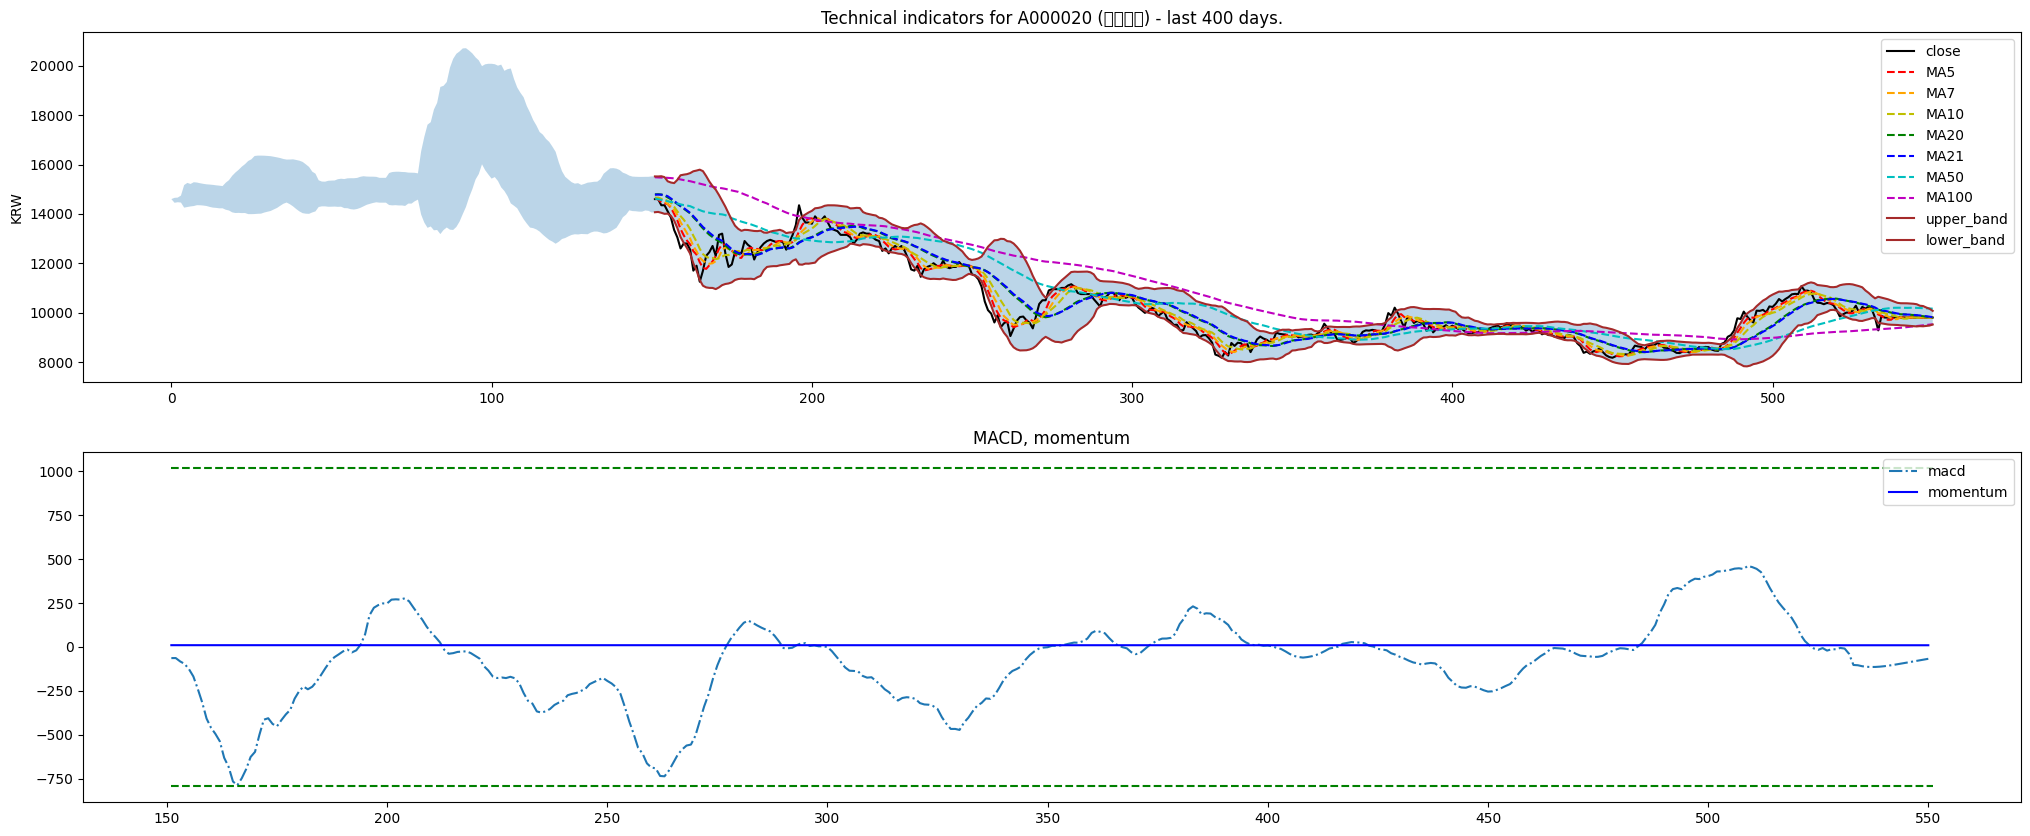

In [ ]:
plot_technical_indicators(train, 'A000020', 400)

**펀더멘털 분석**

In [ ]:
# 뉴스 크롤링, 감성 분석

**노이즈 제거 (푸리에 변환, 웨이블릿 변환, AutoEncoder)**

In [ ]:
# 푸리에 변환
def get_Fourier_Transform(dataset, topN = 2):
  fft = np.fft.fft(dataset['Close'])
  fft[topN:-topN] = 0
  ifft = np.fft.ifft(fft)
  return ifft

train['fft30'] = get_Fourier_Transform(train, 30)
train['fft30'] = train['fft30'].astype('float')

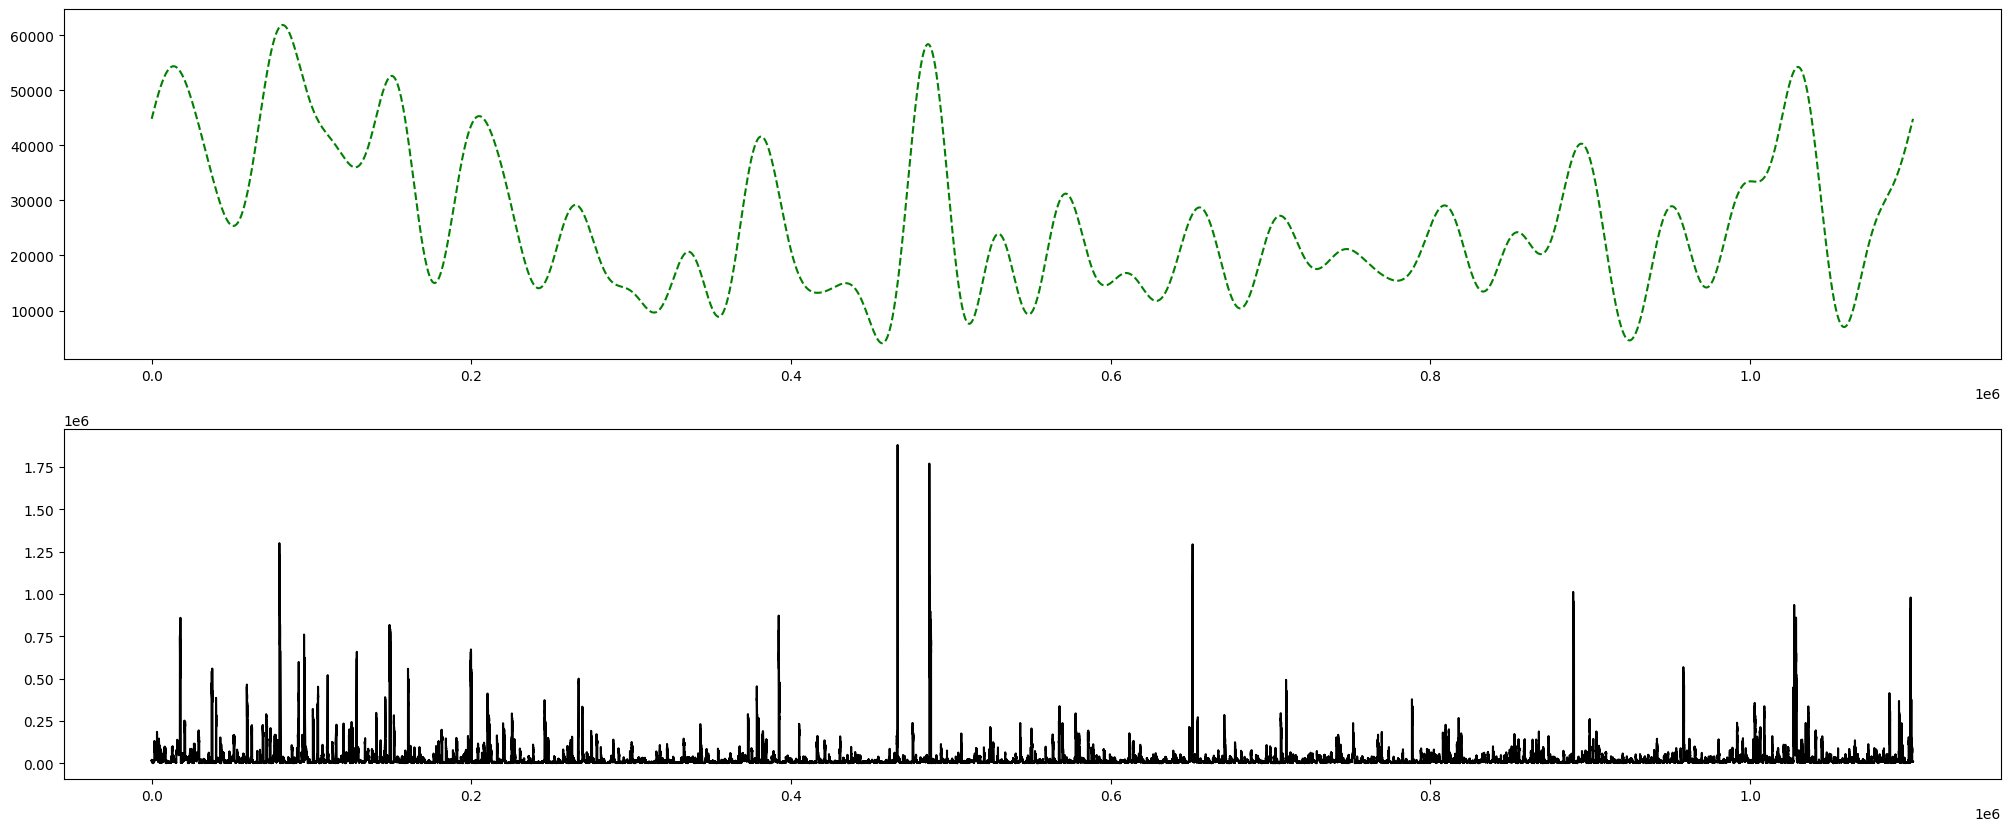

In [ ]:
plt.figure(figsize = (25, 10))
plt.subplot(2, 1, 1)
plt.plot(train['fft30'], label = 'fft30', color = 'g', linestyle = '--')
plt.subplot(2, 1, 2)
plt.plot(train['Close'], label = 'close', color = 'k')
plt.show()

In [ ]:
# 웨이블릿 변환
def get_Wavelet_Transform(dataset, wavelet = 'db5', threshold = 0.63):
  signal = dataset['Close'].values
  thershold = threshold * np.nanmax(signal)
  coeff = pywt.wavedec(signal, wavelet, mode = 'per')
  coeff[1:] = (pywt.threshold(i, value = threshold, mode = 'soft') for i in coeff[1:])
  reconstructed_signal = pywt.waverec(coeff, wavelet, mode = 'per')
  return reconstructed_signal

def get_Wavelet_Transform_v2(dataset, wavelet = 'db4', level = 2):
  signal = dataset['Close'].values
  coeffs = pywt.wavedec(signal, wavelet, level = level)
  threshold = np.sqrt(2 * np.log(len(dataset))) * np.std(coeffs[-level])
  coeffs[1:] = (pywt.threshold(c, threshold) for c in coeffs[1:])
  denoised_data = pywt.waverec(coeffs, wavelet)
  return denoised_data

def get_Wavelet_Transform_v3(dataset, wavelet = 'haar', level = 2, declevel = 2):
  signal = dataset['Close'].values
  coeff = pywt.wavedec(signal, wavelet, mode = 'periodization', level = declevel, axis = 0)
  sigma = mad(coeff[-level])
  uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
  coeff[1:] = (pywt.threshold(i, value = uthresh, mode = 'hard') for i in coeff[1:])
  y = pywt.waverec(coeff, wavelet, mode = 'periodization', axis = 0)
  return y

def get_Wavelet_Transform_v4(dataset, wavelet = 'db4', level = 1, declevel = 2, title = None):
  signal = dataset['Close'].values
  coeff = pywt.wavedec(signal, wavelet, mode = 'per', level = declevel)
  sigma = mad(coeff[-level])
  uthresh = sigma * np.sqrt(2 * np.log(len(signal)))
  coeff[1:] = (pywt.threshold(i, value = uthresh, mode = 'soft') for i in coeff[1:])
  y = pywt.waverec(coeff, wavelet, mode = 'per')
  return y

stacked_wt_data = []
for item_Code in train['item_Code'].unique().tolist():
  data = train[train['item_Code'] == item_Code]
  wt_data = get_Wavelet_Transform_v2(data, wavelet = 'db4', level = 2)
  stacked_wt_data.append(wt_data)
train['wt_db4'] = np.concatenate(stacked_wt_data, axis = 0)

stacked_wt_data = []
for item_Code in train['item_Code'].unique().tolist():
  data = train[train['item_Code'] == item_Code]
  wt_data = get_Wavelet_Transform(data, wavelet = 'db5')
  stacked_wt_data.append(wt_data)
train['wt_db5'] = np.concatenate(stacked_wt_data, axis = 0)

stacked_wt_data = []
for item_Code in train['item_Code'].unique().tolist():
  data = train[train['item_Code'] == item_Code]
  wt_data = get_Wavelet_Transform(data, wavelet = 'db7')
  stacked_wt_data.append(wt_data)
train['wt_db7'] = np.concatenate(stacked_wt_data, axis = 0)

stacked_wt_data = []
for item_Code in train['item_Code'].unique().tolist():
  data = train[train['item_Code'] == item_Code]
  wt_data = get_Wavelet_Transform(data, wavelet = 'db9')
  stacked_wt_data.append(wt_data)
train['wt_db9'] = np.concatenate(stacked_wt_data, axis = 0)

stacked_wt_data = []
for item_Code in train['item_Code'].unique().tolist():
  data = train[train['item_Code'] == item_Code]
  wt_data = get_Wavelet_Transform_v3(data)
  stacked_wt_data.append(wt_data)
train['wt_haar_hard'] = np.concatenate(stacked_wt_data, axis = 0)

stacked_wt_data = []
for item_Code in train['item_Code'].unique().tolist():
  data = train[train['item_Code'] == item_Code]
  wt_data = get_Wavelet_Transform_v4(data)
  stacked_wt_data.append(wt_data)
train['wt_db4_soft'] = np.concatenate(stacked_wt_data, axis = 0)
train['wt_db4_soft'] = train['wt_db4_soft'].ffill().bfill()


# train['wt_db4'] = get_Wavelet_Transform_v2(train, wavelet = 'db4', level = 2)
# train['wt_db5'] = get_Wavelet_Transform(train, wavelet = 'db5')
# train['wt_db7'] = get_Wavelet_Transform(train, wavelet = 'db7')
# train['wt_db9'] = get_Wavelet_Transform(train, wavelet = 'db9')
# train['wt_haar_hard'] = get_Wavelet_Transform_v3(train)
# train['wt_db4_soft'] = get_Wavelet_Transform_v4(train)

ValueError: ignored

In [ ]:
plt.figure(figsize = (25, 10))
plt.subplot(5, 1, 1)
plt.plot(train['wt_db4'], label = 'wt_db4', color = 'g', linestyle = '--')
plt.subplot(5, 1, 2)
plt.plot(train['wt_db5'], label = 'wt_db5', color = 'b', linestyle = '--')
plt.subplot(5, 1, 3)
plt.plot(train['Close'], label = 'close', color = 'k')
plt.subplot(5, 1, 4)
plt.plot(train['wt_haar_hard'], label = 'wt_haar_hard', color = 'r')
plt.subplot(5, 1, 5)
plt.plot(train['wt_db4_soft'], label = 'wt_db4_soft', color = 'y')
plt.show()

In [ ]:
def MAPE(y_test, y_pred):
	return np.mean(np.abs((y_test - y_pred) / y_test)) * 100

def MAE(y_test, y_pred):
  return np.mean(np.abs(y_test - y_pred))

def RMSE(y_test, y_pred):
  MSE = mean_squared_error(y_test, y_pred)
  return np.sqrt(MSE)

In [ ]:
# LSTM-AutoEncoder
class TimeDistributed(nn.Module):
    def __init__(self, module):
      super(TimeDistributed, self).__init__()
      self.module = module

    def forward(self, x):
      if len(x.size()) <= 2:
        return self.module(x)
      x_reshape = x.contiguous().view(-1, x.size(-1))
      y = self.module(x_reshape)
      if len(x.size()) == 3:
        y = y.contiguous().view(x.size(0), -1, y.size(-1))
      return y

class LSTM_AutoEncoder(nn.Module):
    def __init__(self):
      super(LSTM_AutoEncoder, self).__init__()
      self.encoder = nn.LSTM(
          input_size = 1,
          hidden_size = 16,
          dropout = 0.25,
          num_layers = 2,
          bias = True,
          batch_first = True,
          bidirectional = True,
      )
      self.decoder = nn.LSTM(
          input_size = 32,
          hidden_size = 16,
          dropout = 0.25,
          num_layers = 2,
          bias = True,
          batch_first = True,
          bidirectional = True,
      )

      self.fc = TimeDistributed(nn.Linear(32, 1))

    def forward(self, x):
      h0, (h_n, c_n) = self.encoder(x)
      h0, (h_n, c_n) = self.decoder(h0[:, -1:, :].repeat(1, x.size(1), 1))
      out = self.fc(h0)
      return out

# CAE
class CAE(nn.Module):
    def __init__(self):
      super(CAE, self).__init__()
      self.encoder = nn.Sequential(
          nn.Conv1d(1, 16, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU(),
          nn.Conv1d(16, 8, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU(),
      )
      self.decoder = nn.Sequential(
          nn.ConvTranspose1d(8, 16, kernel_size = 3, stride = 1, padding = 1),
          nn.ReLU(),
          nn.ConvTranspose1d(16, 1, kernel_size = 3, stride = 1, padding = 1),
          #nn.Sigmoid(),
      )

    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

# DAE
class DAE(nn.Module):
    def __init__(self, input_size, hidden_size):
      super(DAE, self).__init__()
      self.encoder = nn.Linear(input_size, hidden_size)
      self.decoder = nn.Linear(hidden_size, input_size)

    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

# DDAE
class DDAE(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(DDAE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size//2),
        nn.ReLU(),
        nn.Linear(hidden_size//2, hidden_size),
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.Linear(hidden_size, hidden_size//2),
        nn.ReLU(),
        nn.Linear(hidden_size//2, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, input_size),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

# AE
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
      super(AutoEncoder, self).__init__()
      self.encoder = nn.Sequential(
          nn.Linear(input_size, 64),
          nn.ReLU(),
          nn.Linear(64, 128),
          nn.ReLU(),
          nn.Linear(128, 512),
      )
      self.decoder = nn.Sequential(
          nn.Linear(512, 128),
          nn.ReLU(),
          nn.Linear(128, 64),
          nn.ReLU(),
          nn.Linear(64, input_size),
      )

    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return decoded

In [ ]:
stacked_denoised_data = []

for item_Code in train['item_Code'].unique().tolist():

  print('-' * 20)
  print(f'item_Code: {item_Code}')
  print('-' * 20)

  data = train[train['item_Code'] == item_Code]
  data = data.loc[:, 'Close'].values
  data = torch.tensor(data, dtype = torch.float32).unsqueeze(0) # AE, DAE, DDAE
  #data = torch.tensor(data, dtype = torch.float32).unsqueeze(0).unsqueeze(0) # CAE
  #data = torch.tensor(data, dtype = torch.float32).unsqueeze(0).unsqueeze(-1) # or .view(1, -1, 1) # LSTM-AutoEncoder
  dataloader = DataLoader(data, batch_size = 32, shuffle = False)

  input_size = data.shape[1]
  model = AutoEncoder(input_size)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr = 0.001)

  '''
  Training and Inference
  '''
  model.train()
  num_epochs = 200
  for epoch in range(1, num_epochs + 1):
    train_loss = 0.0
    for batch_data in dataloader:
      inputs = batch_data
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, data)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    avg_loss = train_loss / len(dataloader)
    print(f'Epoch[{epoch+1}/{num_epochs} Loss: {avg_loss}]')

  denoised_data = []
  model.eval()
  with torch.no_grad():
    outputs = model(data).squeeze()
    denoised_data.append(outputs)

  '''
  No Training and Inference
  '''
  # denoised_data = []
  # with torch.no_grad():
  #   for batch_data in dataloader:
  #     inputs = batch_data
  #     outputs = model(inputs)
  #     denoised_data.append(outputs)

  denoised_data = torch.cat(denoised_data, dim = 0)
  stacked_denoised_data.append(denoised_data)
stacked_denoised_data = torch.cat(stacked_denoised_data, dim=0)

In [ ]:
train['Close']

0         14600
1         14500
2         14600
3         14700
4         15150
          ...  
987995     8330
987996     8300
987997     8310
987998     8280
987999     8290
Name: Close, Length: 988000, dtype: int64

In [ ]:
stacked_denoised_data

array([14600.        , 14238.49078365, 14441.31491337, ...,
        8230.        ,  8230.        ,  8230.        ])

In [ ]:
np.save('stacked_denoised_data_autoencoder.npy', stacked_denoised_data)
np.savetxt('stacked_denoised_data_autoencoder.txt', stacked_denoised_data)

np.load('stacked_denoised_data_autoencoder.npy')
np.loadtxt('stacked_denoised_data_autoencoder.txt')

In [ ]:
train['AE_close'] = stacked_denoised_data

In [ ]:
#model_fit

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [ ]:
# Arima
stacked_denoised_data = []

for item_Code in train['item_Code'].unique().tolist():

  print('-' * 20)
  print(f'item_Code: {item_Code}')
  print('-' * 20)

  data = train[train['item_Code'] == item_Code]
  data['Date'] = pd.to_datetime(data['Date'], format='%Y%m%d')
  data.set_index('Date', inplace = True)
  data.index = data.index.to_period('D')
  tc = data['Close']

  model = ARIMA(tc, order = (0, 1, 1)) # (5, 1, 0) (2, 1, 2)
  model_fit = model.fit()

  #print(model_fit.summary())

  output = model_fit.predict()
  output[0] = tc[0]
  #print(output.shape)
  #print(tc)
  #print(output)

  stacked_denoised_data.append(output)
stacked_denoised_data = np.concatenate(stacked_denoised_data, axis=0)

--------------------
item_Code: A000020
--------------------
--------------------
item_Code: A000040
--------------------
--------------------
item_Code: A000050
--------------------
--------------------
item_Code: A000070
--------------------
--------------------
item_Code: A000080
--------------------
--------------------
item_Code: A000100
--------------------
--------------------
item_Code: A000120
--------------------
--------------------
item_Code: A000140
--------------------
--------------------
item_Code: A000150
--------------------
--------------------
item_Code: A000180
--------------------
--------------------
item_Code: A000210
--------------------
--------------------
item_Code: A000220
--------------------
--------------------
item_Code: A000230
--------------------
--------------------
item_Code: A000240
--------------------
--------------------
item_Code: A000250
--------------------
--------------------
item_Code: A000270
--------------------
--------------------
ite

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--------------------
item_Code: A006620
--------------------
--------------------
item_Code: A006650
--------------------
--------------------
item_Code: A006660
--------------------
--------------------
item_Code: A006730
--------------------
--------------------
item_Code: A006740
--------------------
--------------------
item_Code: A006800
--------------------
--------------------
item_Code: A006840
--------------------
--------------------
item_Code: A006880
--------------------
--------------------
item_Code: A006890
--------------------
--------------------
item_Code: A006910
--------------------
--------------------
item_Code: A006980
--------------------
--------------------
item_Code: A007070
--------------------
--------------------
item_Code: A007110
--------------------
--------------------
item_Code: A007120
--------------------
--------------------
item_Code: A007160
--------------------
--------------------
item_Code: A007210
--------------------
--------------------
ite

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--------------------
item_Code: A012610
--------------------
--------------------
item_Code: A012630
--------------------
--------------------
item_Code: A012690
--------------------
--------------------
item_Code: A012700
--------------------
--------------------
item_Code: A012750
--------------------
--------------------
item_Code: A012790
--------------------
--------------------
item_Code: A012800
--------------------
--------------------
item_Code: A012860
--------------------
--------------------
item_Code: A013030
--------------------
--------------------
item_Code: A013120
--------------------
--------------------
item_Code: A013310
--------------------
--------------------
item_Code: A013360
--------------------
--------------------
item_Code: A013520
--------------------
--------------------
item_Code: A013570
--------------------
--------------------
item_Code: A013580
--------------------
--------------------
item_Code: A013700
--------------------
--------------------
ite

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--------------------
item_Code: A015590
--------------------
--------------------
item_Code: A015710
--------------------
--------------------
item_Code: A015750
--------------------
--------------------
item_Code: A015760
--------------------
--------------------
item_Code: A015860
--------------------
--------------------
item_Code: A015890
--------------------
--------------------
item_Code: A016090
--------------------
--------------------
item_Code: A016100
--------------------
--------------------
item_Code: A016250
--------------------
--------------------
item_Code: A016360
--------------------
--------------------
item_Code: A016380
--------------------
--------------------
item_Code: A016450
--------------------
--------------------
item_Code: A016580
--------------------
--------------------
item_Code: A016590
--------------------
--------------------
item_Code: A016600
--------------------
--------------------
item_Code: A016610
--------------------
--------------------
ite

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--------------------
item_Code: A065650
--------------------
--------------------
item_Code: A065660
--------------------
--------------------
item_Code: A065680
--------------------
--------------------
item_Code: A065710
--------------------
--------------------
item_Code: A065950
--------------------
--------------------
item_Code: A066130
--------------------
--------------------
item_Code: A066310
--------------------
--------------------
item_Code: A066360
--------------------
--------------------
item_Code: A066410
--------------------
--------------------
item_Code: A066570
--------------------
--------------------
item_Code: A066590
--------------------
--------------------
item_Code: A066620
--------------------
--------------------
item_Code: A066670
--------------------
--------------------
item_Code: A066700
--------------------
--------------------
item_Code: A066900
--------------------
--------------------
item_Code: A066910
--------------------
--------------------
ite

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--------------------
item_Code: A069260
--------------------
--------------------
item_Code: A069410
--------------------
--------------------
item_Code: A069460
--------------------
--------------------
item_Code: A069510
--------------------
--------------------
item_Code: A069540
--------------------
--------------------
item_Code: A069620
--------------------
--------------------
item_Code: A069640
--------------------
--------------------
item_Code: A069730
--------------------
--------------------
item_Code: A069920
--------------------
--------------------
item_Code: A069960
--------------------
--------------------
item_Code: A070960
--------------------
--------------------
item_Code: A071050
--------------------
--------------------
item_Code: A071090
--------------------
--------------------
item_Code: A071200
--------------------
--------------------
item_Code: A071280
--------------------
--------------------
item_Code: A071320
--------------------
--------------------
ite

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--------------------
item_Code: A109080
--------------------
--------------------
item_Code: A109610
--------------------
--------------------
item_Code: A109740
--------------------
--------------------
item_Code: A109820
--------------------
--------------------
item_Code: A109860
--------------------
--------------------
item_Code: A109960
--------------------
--------------------
item_Code: A110790
--------------------
--------------------
item_Code: A110990
--------------------
--------------------
item_Code: A111110
--------------------
--------------------
item_Code: A111710
--------------------
--------------------
item_Code: A111770
--------------------
--------------------
item_Code: A112040
--------------------
--------------------
item_Code: A112610
--------------------
--------------------
item_Code: A113810
--------------------
--------------------
item_Code: A114090
--------------------
--------------------
item_Code: A114190
--------------------
--------------------
ite

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--------------------
item_Code: A160980
--------------------
--------------------
item_Code: A161000
--------------------
--------------------
item_Code: A161390
--------------------
--------------------
item_Code: A161580
--------------------
--------------------
item_Code: A161890
--------------------
--------------------
item_Code: A163560
--------------------
--------------------
item_Code: A163730
--------------------
--------------------
item_Code: A164060
--------------------
--------------------
item_Code: A166090
--------------------
--------------------
item_Code: A166480
--------------------
--------------------
item_Code: A168330
--------------------
--------------------
item_Code: A169330
--------------------
--------------------
item_Code: A170030
--------------------
--------------------
item_Code: A170790
--------------------
--------------------
item_Code: A170900
--------------------
--------------------
item_Code: A170920
--------------------
--------------------
ite

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


--------------------
item_Code: A258610
--------------------
--------------------
item_Code: A258830
--------------------
--------------------
item_Code: A259630
--------------------
--------------------
item_Code: A260660
--------------------
--------------------
item_Code: A260930
--------------------
--------------------
item_Code: A260970
--------------------
--------------------
item_Code: A261200
--------------------
--------------------
item_Code: A262260
--------------------
--------------------
item_Code: A262840
--------------------
--------------------
item_Code: A263020
--------------------
--------------------
item_Code: A263050
--------------------
--------------------
item_Code: A263540
--------------------
--------------------
item_Code: A263600
--------------------
--------------------
item_Code: A263690
--------------------
--------------------
item_Code: A263700
--------------------
--------------------
item_Code: A263720
--------------------
--------------------
ite

In [ ]:
train['Close']

0          14600
1          14500
2          14600
3          14700
4          15150
           ...  
1085995     8230
1085996     8230
1085997     8230
1085998     8230
1085999     8230
Name: Close, Length: 1086000, dtype: int64

In [ ]:
stacked_denoised_data

array([14600.        , 14234.06712611, 14440.36208249, ...,
        8229.99999687,  8230.00000018,  8229.99999999])

In [ ]:
np.save('stacked_denoised_arima.npy', stacked_denoised_data)
np.savetxt('stacked_denoised_arima.txt', stacked_denoised_data)

np.load('stacked_denoised_arima.npy')
np.loadtxt('stacked_denoised_arima.txt')

array([14600.        , 14234.06712611, 14440.36208249, ...,
        8229.99999687,  8230.00000018,  8229.99999999])

In [ ]:
train['ARIMA_close'] = stacked_denoised_data

In [ ]:
metrics = ['fft30', 'wt_db4', 'wt_db5', 'wt_db7', 'wt_db9', 'AE_close', 'wt_haar_hard', 'wt_db4_soft']
rmses = [RMSE(train['Close'], train['fft30']), RMSE(train['Close'], train['wt_db4']), RMSE(train['Close'], train['wt_db5']), RMSE(train['Close'], train['wt_db7']), RMSE(train['Close'], train['wt_db9']), RMSE(train['Close'], train['AE_close']), RMSE(train['Close'], train['wt_haar_hard']), RMSE(train['Close'], train['wt_db4_soft'])]
maes = [MAE(train['Close'], train['fft30']), MAE(train['Close'], train['wt_db4']), MAE(train['Close'], train['wt_db5']), MAE(train['Close'], train['wt_db7']), MAE(train['Close'], train['wt_db9']), MAE(train['Close'], train['AE_close']), MAE(train['Close'], train['wt_haar_hard']), MAE(train['Close'], train['wt_db4_soft'])]
mapes = [MAPE(train['Close'], train['fft30']), MAPE(train['Close'], train['wt_db4']), MAPE(train['Close'], train['wt_db5']), MAPE(train['Close'], train['wt_db7']), MAPE(train['Close'], train['wt_db9']), MAPE(train['Close'], train['AE_close']), MAPE(train['Close'], train['wt_haar_hard']), MAPE(train['Close'], train['wt_db4_soft'])]
print('RMSE')
print(f'{metrics[0]}:', rmses[0])
print(f'{metrics[1]}:', rmses[1])
print(f'{metrics[2]}:', rmses[2])
print(f'{metrics[3]}:', rmses[3])
print(f'{metrics[4]}:', rmses[4])
print(f'{metrics[-3]}:', rmses[-3])
print(f'{metrics[-2]}:', rmses[-2])
print(f'{metrics[-1]}:', rmses[-1])

print('MAE')
print(f'{metrics[0]}:', maes[0])
print(f'{metrics[1]}:', maes[1])
print(f'{metrics[2]}:', maes[2])
print(f'{metrics[3]}:', maes[3])
print(f'{metrics[4]}:', maes[4])
print(f'{metrics[-3]}:', maes[-3])
print(f'{metrics[-2]}:', maes[-2])
print(f'{metrics[-1]}:', maes[-1])

print('MAPE')
print(f'{metrics[0]}:', mapes[0])
print(f'{metrics[1]}:', mapes[1])
print(f'{metrics[2]}:', mapes[2])
print(f'{metrics[3]}:', mapes[3])
print(f'{metrics[4]}:', mapes[4])
print(f'{metrics[-3]}:', mapes[-3])
print(f'{metrics[-2]}:', mapes[-2])
print(f'{metrics[-1]}:', mapes[-1])

RMSE
fft30: 64456.13379253148
wt_db4: 1148.9728500551983
wt_db5: 0.6136788319744778
wt_db7: 0.6130982811551873
wt_db9: 0.6037773511208163
AE_close: 173.43731123254327
wt_haar_hard: 1122.859398767858
wt_db4_soft: 929.2606039371385
MAE
fft30: 27780.62126965052
wt_db4: 321.37102786554976
wt_db5: 0.5026797986721024
wt_db7: 0.498427978389635
wt_db9: 0.48884582060307546
AE_close: 12.168059314974888
wt_haar_hard: 329.115214068826
wt_db4_soft: 283.4337018863936
MAPE
fft30: 496.51851793241696
wt_db4: 1.3684707972213275
wt_db5: 0.011082395480888237
wt_db7: 0.011010036971094558
wt_db9: 0.010796483376951944
AE_close: 0.052729876307533535
wt_haar_hard: 1.3804305108751287
wt_db4_soft: 1.214271959707792


In [ ]:
metrics = ['ARIMA_close']
rmses = [RMSE(train['Close'], train['ARIMA_close'])]
maes = [MAE(train['Close'], train['ARIMA_close'])]
mapes = [MAPE(train['Close'], train['ARIMA_close'])]
print('RMSE')
print(f'{metrics[-1]}:', rmses[-1])

print('MAE')
print(f'{metrics[-1]}:', maes[-1])

print('MAPE')
print(f'{metrics[-1]}:', mapes[-1])

RMSE
ARIMA_close: 2608.2184106590034
MAE
ARIMA_close: 471.5799166365837
MAPE
ARIMA_close: inf


In [ ]:
#train['ARIMA_close'] = np.round(train['ARIMA_close'])

In [ ]:
temp = np.sum([rmses,maes,mapes], axis = 0)
metrics[temp.argmin()]

'wt_db9'

# **기능 중요도**

- 상관자산, 기술지표, 기본 분석, 푸리에, 웨이블릿, 아리마, 오토인코더 등

In [ ]:
train.drop(['fft30', 'wt_db4', 'wt_db5', 'wt_db7', 'AE_close'], axis = 1, inplace = True)

In [ ]:
train

,Date,item_Code,item_Name,Volume,Open,High,Low,Close,ma5,ma7,...,au,ad,rsi,rsi_Signal,volume_price,volume_price_sum,volume_sum,vwap,diff,wt_db9
0,20210601,A000020,동화약품,114966,14700,14700,14450,14600,NaN,NaN,...,NaN,NaN,NaN,NaN,1690000200,1690000200,114966,14700.000000,0.000000,14599.063047
1,20210602,A000020,동화약품,109559,14700,14700,14450,14500,NaN,NaN,...,NaN,NaN,NaN,NaN,1610517300,3300517500,224525,14700.000000,0.000000,14499.344630
2,20210603,A000020,동화약품,96158,14550,14650,14450,14600,NaN,NaN,...,NaN,NaN,NaN,NaN,1399098900,4699616400,320683,14655.021938,-105.021938,14599.757525
3,20210604,A000020,동화약품,133900,14600,14800,14550,14700,NaN,NaN,...,NaN,NaN,NaN,NaN,1954940000,6654556400,454583,14638.814914,-38.814914,14699.270109
4,20210607,A000020,동화약품,511140,14800,15550,14750,15150,14710.0,NaN,...,NaN,NaN,NaN,NaN,7564872000,14219428400,965723,14724.127312,75.872688,15148.996570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987995,20230523,A383800,LX홀딩스,150364,8390,8390,8310,8330,8354.0,8354.285714,...,10.714286,25.714286,29.411765,33.866817,1261553960,1425993825510,144805856,9847.625399,-1457.625399,8331.201210
987996,20230524,A383800,LX홀딩스,122457,8310,8340,8280,8300,8338.0,8347.142857,...,9.285714,27.857143,25.000000,32.477928,1017617670,1427011443180,144928313,9846.326185,-1536.326185,8300.986750
987997,20230525,A383800,LX홀딩스,84241,8300,8310,8270,8310,8330.0,8340.000000,...,7.857143,27.857143,22.000000,30.922372,699200300,1427710643480,145012554,9845.427890,-1545.427890,8310.174317
987998,20230526,A383800,LX홀딩스,126681,8300,8310,8270,8280,8316.0,8325.714286,...,3.571429,30.000000,10.638298,28.400702,1051452300,1428762095780,145139235,9844.079003,-1544.079003,8281.043452


In [ ]:
train['NASDAQCOM'] = pd.to_numeric(train['NASDAQCOM'], errors='coerce')
train['BAMLH0A0HYM2EY'] = pd.to_numeric(train['BAMLH0A0HYM2EY'], errors='coerce')

In [10]:
def train_test_split(dataset, close_name):
  dataset = dataset.copy()
  y = dataset[close_name]
  X = dataset.drop([close_name], axis = 1)
  train_samples = int(np.ceil(0.8 * X.shape[0])) #int(X.shape[0] * 0.75)

  X_train = X.iloc[:train_samples]
  X_test = X.iloc[train_samples:]
  y_train = y.iloc[:train_samples]
  y_test = y.iloc[train_samples:]

  return (X_train, y_train), (X_test, y_test)

In [ ]:
train.head()

,Date,item_Code,item_Name,Volume,Open,High,Low,Close,Date_ym,Close_usd_krw,...,SR,WR,AO,KAMA,ROC,PPO,PVO,Daily_Range,Mean,ARIMA_close
0,20210601,A000020,동화약품,114966,14700,14700,14450,14600,202106,1106.979980,...,60.000000,-40.000000,0.0,14600.000000,0.0,0.000000,0.000000,-100,14575.0,14600.000000
1,20210602,A000020,동화약품,109559,14700,14700,14450,14500,202106,1107.209961,...,20.000000,-80.000000,0.0,14599.583767,0.0,-0.054666,-0.376490,-200,14575.0,14234.067126
2,20210603,A000020,동화약품,96158,14550,14650,14450,14600,202106,1109.880005,...,60.000000,-40.000000,0.0,14599.585499,0.0,-0.042205,-1.619559,50,14550.0,14440.362082
3,20210604,A000020,동화약품,133900,14600,14800,14550,14700,202106,1115.439941,...,71.428571,-28.571429,0.0,14600.003458,0.0,0.022689,0.086992,100,14675.0,14562.525683
4,20210607,A000020,동화약품,511140,14800,15550,14750,15150,202106,1109.680054,...,63.636364,-36.363636,0.0,14602.292725,0.0,0.318224,22.003352,350,15150.0,14667.648856


In [ ]:
train.to_parquet('full_train.parquet')
#train = pd.read_parquet('full_train.parquet')

In [ ]:
fi_list = []

for item_Code in train['item_Code'].unique().tolist():

  print('-' * 20)
  print(f'item_Code: {item_Code}')
  print('-' * 20)

  item_set = train[train['item_Code'] == item_Code]
  item_set = item_set.drop(['Date', 'item_Code', 'item_Name', 'ARIMA_close'], axis = 1)
  (X_train_fi, y_train_fi), (X_test_fi, y_test_fi) = train_test_split(item_set)
  regressor = xgb.XGBRegressor() # gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05
  regressor = regressor.fit(X_train_fi, y_train_fi, eval_set = [(X_train_fi, y_train_fi), (X_test_fi, y_test_fi)], verbose = False)

  #fi_mean = np.mean(regressor.feature_importances_)
  #print(dict(zip(item_set.columns, regressor.feature_importances_)))
  fi = X_train_fi.columns[np.array(regressor.feature_importances_) > 0.0]
  print('len:', len(fi))
  print(fi)
  fi_list.append(fi)

  # eval_result = regressor.evals_result()
  # training_rounds = range(len(eval_result['validation_0']['rmse']))

  # fig = plt.figure(figsize=(15,7))

  # plt.subplot(2, 1, 1)
  # plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
  # plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
  # plt.xlabel('Iterations')
  # plt.ylabel('RMSE')
  # plt.title('Training Vs Validation Error')
  # plt.legend()

  # plt.subplot(2, 1, 2)
  # plt.xticks(rotation='vertical')
  # plt.bar([i for i in range(len(regressor.feature_importances_))], regressor.feature_importances_.tolist(), tick_label=X_test_fi.columns)
  # plt.title('Figure 6: Feature importance of the technical indicators.')
  # plt.show()

# Stacked AutoEncoder

In [ ]:
class Stacked_Autoencoder(nn.Module):
    def __init__(self, n_in, n_hidden = 10):
      super(Stacked_Autoencoder, self).__init__()
      self.n_in = n_in
      self.n_hidden = n_hidden
      self.build_model()

    def build_model(self):
      self.encoder = nn.Sequential(
          nn.Linear(self.n_in, self.n_hidden),
          nn.Sigmoid()
      )
      self.decoder = nn.Sequential(
          nn.Linear(self.n_hidden, self.n_in),
          #nn.Sigmoid()
      )

    def forward(self, x):
      encoder = self.encoder(x)
      decoder = self.decoder(encoder)
      return decoder

In [ ]:
def gelu(x):
    return 0.5 * x * (1 + math.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * math.pow(x, 3))))

In [ ]:
class Stacked_VAE(nn.Module):
    def __init__(self, n_in = 784, n_hidden = 400, n_latent = 2):
      super(Stacked_VAE, self).__init__()
      self.n_in = n_in
      self.n_latent = n_latent
      self.n_hidden = n_hidden

      self.encoder = nn.Sequential(
        nn.Linear(n_in, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_latent * 2)
      )

      self.decoder = nn.Sequential(
          nn.Linear(n_latent, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, n_hidden),
          nn.ReLU(),
          nn.Linear(n_hidden, n_in),
          nn.Sigmoid()
      )

    def encoded(self, x):
      h = self.encoder(x)
      mu, log_var = torch.chunk(h, 2, dim = 1)
      return mu, log_var

    def reparameterize(self, mu, log_var):
      std = torch.exp(0.5 * log_var)
      eps = torch.randn_like(std)
      z = mu + eps * std
      return z

    def decoded(self, z):
      return self.decoder(z)

    def forward(self, x):
      mu, log_var = self.encoded(x)
      z = self.reparameterize(mu, log_var)
      y = self.decoded(z)

      return y, mu, log_var

def vae_loss(recon_x, x, mu, log_var):
  BCE =  F.binary_cross_entropy(recon_x, x, reduction='sum') #nn.MSELoss()(recon_x, x) #F.mse_loss(recon_x, x, reduction='sum') # binary_cross_entropy
  KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

  return BCE + KLD

In [ ]:
class Stacked_VAE(nn.Module):
    def __init__(self, n_in=784, n_hidden=400, n_latent=2, n_layers=1):
      super(Stacked_VAE, self).__init__()
      self.soft_zero = 1e-10
      self.n_latent = n_latent
      self.n_in = n_in
      self.mu = None

      encoder_layers = []
      for i in range(n_layers):
        in_features = n_in if i == 0 else n_hidden
        out_features = n_latent *2 if i == n_layers - 1 else n_hidden
        encoder_layers.append(nn.Linear(in_features, out_features))
        if i < n_layers - 1:
          encoder_layers.append(nn.ReLU())
      #encoder_layers.append(nn.ReLU())
      self.encoder = nn.Sequential(*encoder_layers)

      decoder_layers = []
      for i in range(n_layers):
        in_features = n_latent if i == 0 else n_hidden
        out_features = n_in if i == n_layers - 1 else n_hidden
        decoder_layers.append(nn.Linear(in_features, out_features))
        if i < n_layers - 1:
          decoder_layers.append(nn.ReLU())
      decoder_layers.append(nn.Sigmoid())
      self.decoder = nn.Sequential(*decoder_layers)

    def encoded(self, x):
      h = self.encoder(x)
      mu_lv = torch.split(h, self.n_latent, dim=1)
      return mu_lv[0], mu_lv[1]

    def decoded(self, z):
      return self.decoder(z)

    def reparameterize(self, mu, lv):
      eps = torch.randn_like(mu)
      z = mu + torch.exp(0.5 * lv) * eps
      return z

    def forward(self, x):
      mu, lv = self.encoded(x)
      z = self.reparameterize(mu, lv)
      y = self.decoded(z)

      KL = 0.5 * torch.sum(1 + lv - mu * mu - lv.exp(), dim=1)
      logloss = torch.sum(x * torch.log(y + self.soft_zero) + (1 - x) * torch.log(1 - y + self.soft_zero), dim=1)
      loss = -logloss - KL

      weight_loss = loss.unsqueeze(1)

      return y, weight_loss

In [ ]:
train.shape

(1086000, 96)

In [ ]:
train['Close2'] = train['Close'] # close or use arima close
train.drop(['Close'], axis = 1, inplace = True)

standard scaling
close2
n_epoch = 150
batch_size = 64
learning_rate = 0.01
n_hidden = 32
n_latent = 10
n_layers = 3
close2
Stacked_VAE(n_in = feats_train.shape[1], n_hidden = n_hidden, n_latent = n_latent, n_layers = n_layers) - stacked_vae_filter_data

standard scaling
close2
n_epoch = 150
batch_size = 64
learning_rate = 0.01
n_hidden = 32
n_latent = 10
n_layers = 3
close2
Stacked_VAE(n_in = feats_train.shape[1], n_hidden = n_hidden, n_latent = n_latent) - stacked_vae_filter_data1

standard scaling
close2
n_epoch = 150
batch_size = 64
learning_rate = 0.001
n_hidden = 32
n_latent = 10
n_layers = 3
close2
Stacked_VAE(n_in = feats_train.shape[1], n_hidden = n_hidden, n_latent = n_latent, n_layers = n_layers) - stacked_vae_filter_data2

standard scaling
close2
n_epoch = 150
batch_size = 64
learning_rate = 0.001
n_hidden = 32
n_latent = 10
n_layers = 3
close2
Stacked_VAE(n_in = feats_train.shape[1], n_hidden = n_hidden, n_latent = n_latent) - stacked_vae_filter_data3

In [ ]:
train[train['item_Code']=='A180400']

,Date,item_Code,item_Name,Volume,Open,High,Low,Date_ym,Close_usd_krw,Close_usd_eur,...,WR,AO,KAMA,ROC,PPO,PVO,Daily_Range,Mean,ARIMA_close,Close2
836763,20210601,A180400,DXVX,0,0,0,0,202106,1106.979980,0.817470,...,-50.000000,0.000000,7740.000000,0.000000,0.000000,0.000000,7740,0.0,7740.000000,7740
836764,20210602,A180400,DXVX,0,0,0,0,202106,1107.209961,0.818480,...,-50.000000,0.000000,7740.000000,0.000000,0.000000,0.000000,7740,0.0,7716.064017,7740
836765,20210603,A180400,DXVX,0,0,0,0,202106,1109.880005,0.819010,...,-50.000000,0.000000,7740.000000,0.000000,0.000000,0.000000,7740,0.0,7736.440496,7740
836766,20210604,A180400,DXVX,0,0,0,0,202106,1115.439941,0.824198,...,-50.000000,0.000000,7740.000000,0.000000,0.000000,0.000000,7740,0.0,7739.458953,7740
836767,20210607,A180400,DXVX,0,0,0,0,202106,1109.680054,0.821800,...,-50.000000,0.000000,7740.000000,0.000000,0.000000,0.000000,7740,0.0,7739.917719,7740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837301,20230728,A180400,DXVX,106884,7000,7150,6930,202307,1283.880005,0.907500,...,-68.421053,-630.147059,7066.721941,0.140449,-3.016026,-17.197935,130,7040.0,7129.588733,7130
837302,20230728,A180400,DXVX,106884,7000,7150,6930,202307,1272.810059,0.910850,...,-68.421053,-580.441176,7066.985325,-1.246537,-2.895164,-19.672918,130,7040.0,7129.937455,7130
837303,20230728,A180400,DXVX,106884,7000,7150,6930,202307,1272.810059,0.910850,...,-68.421053,-541.470588,7067.247613,-0.972222,-2.768100,-21.663651,130,7040.0,7129.990488,7130
837304,20230728,A180400,DXVX,106884,7000,7150,6930,202307,1272.810059,0.907500,...,-78.448276,-501.764706,7067.508809,-8.354756,-2.637507,-23.222156,130,7040.0,7129.998553,7130


In [ ]:
forcated_g_concat = []

n_epoch = 200 # 200
batch_size = 64 #64
learning_rate = 0.001 # 0.01

n_hidden = 64 #32
n_latent = 10
n_layers = 2 #3

# zero_item_Code = ['A006580',
#   'A012600',
#   'A015540',
#   'A033340',
#   'A065560',
#   'A069110',
#   'A078590',
#   'A099520',
#   'A109070',
#   'A160600',
#   'A178780',
#   'A223310',
#   'A257370',
#   'A263540']

zero_item_Code = [
  'A006580'
  'A012600'
  'A015540'
  'A033340'
  'A065560'
  'A069110'
  'A078590'
  'A099520'
  'A109070'
  'A160600'
  'A178780'
  'A257370'
  'A263540'
  ]

stacked_vae_filter_data = []

for n, item_Code in enumerate(train['item_Code'].unique().tolist()):

  print('-' * 20)
  print(f'count: {n}, item_Code: {item_Code}')
  print('-' * 20)

  item_set = train[train['item_Code'] == item_Code]
  item_set = item_set.drop(['Date', 'item_Code', 'item_Name', 'ARIMA_close'], axis = 1)

  print('Before feature importances', item_set.shape)

  # if item_Code in zero_item_Code:
  #   print(f'{item_Code} is zero')
  #   stacked_vae_filter_data.append(torch.Tensor(item_set['Close2'].values))
  #   continue

  #item_set = item_set.astype(float)
  item_set = item_set.fillna(method = 'ffill')
  item_set = item_set.fillna(method = 'bfill')
  print(item_set.isnull().sum()[item_set.isnull().sum() > 0])
  columns_list = item_set.columns.tolist()

  # scaling
  scaler = StandardScaler()
  #scaler = RobustScaler()
  #scaler = MinMaxScaler(feature_range = (0, 1))
  scaler = scaler.fit(item_set.drop(['Close2'], axis = 1))
  item_set_scaled = scaler.transform(item_set.drop(['Close2'], axis = 1))
  print(item_set_scaled.shape, item_set['Close2'].shape)
  item_set_scaled = np.hstack((item_set_scaled, np.array(item_set['Close2']).reshape(-1, 1)))
  item_set_scaled_df = pd.DataFrame(item_set_scaled, columns = columns_list)

  (X_train_fi, y_train_fi), (X_test_fi, y_test_fi) = train_test_split(item_set_scaled_df, 'Close2')
  regressor = xgb.XGBRegressor()
  regressor = regressor.fit(X_train_fi, y_train_fi, eval_set = [(X_train_fi, y_train_fi), (X_test_fi, y_test_fi)], verbose = False)

  fi = X_train_fi.columns[np.array(regressor.feature_importances_) > 0.0].tolist()
  #fi.append('Close2')
  fi.append('ARIMA_close')
  #print('len:', len(fi))

  item_set = train[train['item_Code'] == item_Code]
  item_set = item_set[list(set(fi))]

  print('after feature importances', item_set.shape)

  item_set = item_set.astype(float)
  item_set = item_set.fillna(method = 'ffill')
  item_set = item_set.fillna(method = 'bfill')
  print(item_set.isnull().sum()[item_set.isnull().sum() > 0])

  if item_set.shape[1] < 2:
    print(f'{item_Code} is zero')
    stacked_vae_filter_data.append(torch.Tensor(item_set['ARIMA_close'].values))
    continue

  # scaling
  #scaler = StandardScaler()
  #scaler = RobustScaler()
  scaler = MinMaxScaler(feature_range = (0, 1))
  scaler = scaler.fit(item_set.drop(['ARIMA_close'], axis = 1))
  item_set_scaled = scaler.transform(item_set.drop(['ARIMA_close'], axis = 1))

  num_training_days = int(np.ceil(0.8 * item_set.shape[0]))

  feats_item_set = item_set_scaled[:, :]
  feats_train = item_set_scaled[:num_training_days, :]
  feats_test = item_set_scaled[num_training_days:, :]

  data_close = torch.tensor(item_set['ARIMA_close'].values)

  feats_train_tensor = torch.tensor(feats_train, dtype = torch.float32)
  feats_test_tensor = torch.tensor(feats_test, dtype = torch.float32)

  train_loader = DataLoader(feats_train_tensor,  batch_size = batch_size, shuffle = False)
  test_loader = DataLoader(feats_test_tensor, batch_size = batch_size, shuffle = False)

  if feats_train.shape[1] > 64:
    n_hidden = 64
  else:
    n_hidden = 32

  model = Stacked_VAE(n_in = feats_train.shape[1], n_hidden = n_hidden, n_latent = n_latent, n_layers = n_layers)
  #model = Stacked_VAE(n_in = feats_train.shape[1], n_hidden = n_hidden, n_latent = n_latent)
  optimizer = optim.Adam(model.parameters(), lr = learning_rate)
  loss_function = nn.MSELoss()
  #print(model)

  training_loss = []
  validation_loss = []
  for epoch in range(n_epoch):
    epoch_loss = 0
    epoch_val_loss = 0

    model.train()
    for data in train_loader:
      optimizer.zero_grad()
      outputs, weight_loss = model(data)
      loss = loss_function(outputs, data)
      loss = loss + torch.mean(weight_loss)
      #recon_batch, mu, log_var = model(data)
      #loss = vae_loss(recon_batch, data, mu, log_var)
      loss.backward()
      optimizer.step()
      epoch_loss += loss.item()

    model.eval()
    with torch.no_grad():
      for data in test_loader:
        outputs, weight_loss = model(data)
        loss = loss_function(outputs, data)
        loss = loss + torch.mean(weight_loss)
        #recon_batch, mu, log_var = model(data)
        #loss = vae_loss(recon_batch, data, mu, log_var)
        epoch_val_loss += loss.item()

    epoch_loss /= len(train_loader)
    epoch_val_loss /= len(test_loader)

    training_loss.append(epoch_loss)
    validation_loss.append(epoch_val_loss)

    if epoch % 50 == 0:
      print('Epoch {}, Training loss {:.4f}, Validation loss {:.4f}'.format(epoch, epoch_loss, epoch_val_loss))

  feats_data = torch.tensor(feats_item_set, dtype = torch.float32)
  mu, lv = model.encoded(feats_data)
  z = model.reparameterize(mu, lv)
  decoded_data = model.decoded(z)
  print(decoded_data.shape)
  decoded_data = torch.cat((torch.tensor(scaler.inverse_transform(decoded_data.detach().numpy())), data_close.view(543, 1)), dim = 1)
  print(decoded_data.shape)
  stacked_vae_filter_data.append(decoded_data)
#stacked_vae_filter_data_ = torch.cat(stacked_vae_filter_data, dim=0)
#print(stacked_vae_filter_data_.shape)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
--------------------
Before feature importances (543, 92)
Series([], dtype: int64)
(543, 91) (543,)
after feature importances (543, 88)
Series([], dtype: int64)
Epoch 0, Training loss 60.9158, Validation loss 60.0967
Epoch 50, Training loss 50.0078, Validation loss 53.9283
Epoch 100, Training loss 48.9794, Validation loss 53.2060
Epoch 150, Training loss 48.3028, Validation loss 52.6490
torch.Size([543, 87])
torch.Size([543, 88])
--------------------
count: 1643, item_Code: A215200
--------------------
Before feature importances (543, 92)
Series([], dtype: int64)
(543, 91) (543,)
after feature importances (543, 88)
Series([], dtype: int64)
Epoch 0, Training loss 60.8971, Validation loss 61.1882
Epoch 50, Training loss 53.6756, Validation loss 60.7807
Epoch 100, Training loss 52.8672, Validation loss 58.9305
Epoch 150, Training loss 52.4704, Validation loss 58.4295
torch.Size([543, 87])
torch.Size([543, 88])
--------------------
count: 1644, item_Code

In [ ]:
len(stacked_vae_filter_data)

2000

In [ ]:
# train.item_Code.unique().tolist().index('A006580')

In [11]:
os.listdir('/content/drive/MyDrive/open (2)/')

['train_additional.csv',
 'past_open',
 'full_train.parquet',
 'stacked_vae_nf_arima_stdv.npy']

In [12]:
#np.save('stacked_vae_nf_arima_std.npy', stacked_vae_filter_data)
stacked_vae_filter_data = np.load('/content/drive/MyDrive/open (2)/stacked_vae_nf_arima_stdv.npy', allow_pickle = True)

In [13]:
stacked_vae_filter_data = {idx:torch.tensor(data) for idx, data in enumerate(stacked_vae_filter_data)}

# train.parquet - not daily_range, mean
# train.parquet (1) - add daily_range, mean

# LSTM

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 100, n_layers = 5, dropout = 0.5, output_size = 15):
      super(LSTM, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.n_layers = n_layers
      self.dropout = dropout
      self.output_size = output_size
      self.lstm = nn.LSTM(input_size, hidden_size, n_layers, dropout = dropout, batch_first = True)
      self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
      h0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_size)).to(device)
      c0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_size)).to(device)
      output, (hn, cn) = self.lstm(x, (h0, c0))
      out = self.fc(output[:, -self.output_size, :])
      return out

class BiLSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 100, n_layers = 5, dropout = 0.5, output_size = 15):
      super(BiLSTM, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.n_layers = n_layers
      self.dropout = dropout
      self.output_size = output_size
      self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = n_layers, bidirectional = True, dropout = dropout, batch_first = True)
      self.fc = nn.Linear(hidden_size * 2, output_size)
      self.relu = nn.ReLU()

    def forward(self, x):
      h0 = Variable(torch.zeros(self.n_layers * 2, x.size(0), self.hidden_size)).to(device)
      c0 = Variable(torch.zeros(self.n_layers * 2, x.size(0), self.hidden_size)).to(device)
      output, (hn, cn) = self.lstm(x, (h0, c0))
      out = self.fc(output[:, -self.output_size, :])
      out = self.relu(out)
      return out

class biGRU(nn.Module) :
    def __init__(self, input_size = 1, hidden_size = 100, n_layers = 5, output_size = 15):
      super(biGRU, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.n_layers = n_layers
      self.dropout = dropout
      self.output_size = output_size

      self.gru = nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = n_layers, bidirectional=True, batch_first=True)
      self.fc = nn.Linear(hidden_size * 2, output_size)
      self.relu = nn.ReLU()

    def forward(self, x) :
      h_0 = Variable(torch.zeros(self.n_layers * 2, x.size(0), self.hidden_size)).to(device)
      out, _ = self.gru(x, (h_0))
      out = self.fc(out[:, -self.output_size, :])
      out = self.relu(out)
      return out

class VanillaRNN(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 100, n_layers = 5, dropout = 0.5, output_size = 15):
      super(VanillaRNN, self).__init__()
      self.input_size = input_size
      self.hidden_size = hidden_size
      self.n_layers = n_layers
      self.dropout = dropout
      self.output_size = output_size
      self.rnn = nn.RNN(input_size, hidden_size, n_layers, batch_first = True)
      self.fc = nn.Sequential(nn.Linear(hidden_size, output_size), nn.Sigmoid())

    def forward(self, x):
      h0 = Variable(torch.zeros(self.n_layers, x.size(0), self.hidden_size)).to(device)
      output, _ = self.rnn(x, h0)
      out = self.fc(output[:, -self.output_size, :])
      return out

In [15]:
print(torch.cuda.is_available())

True


In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [17]:
device

device(type='cuda')

In [18]:
CUDA_LAUNCH_BLOCKING=1
#CUBLAS_WORKSPACE_CONFIG=:16:8
#CUBLAS_WORKSPACE_CONFIG=:4096:2

In [19]:
prediction_window = 15
window_size = 60

num_epochs = 200 # 100
learning_rate = 0.001 # 0.0001
batch_size = 64 # 32

hidden_size = 64 # 16, 32, 50, 64 # biLSTM->16 * 2 = 32 32 * 2 64 장기 종속성을 캡처해야 하는 경우 더 큰 hidden_size가 필요할 수 있음 128, 256
n_layers = 3
dropout = 0.1 # 데이터 세트가 큰 경우 과적합이 발생할 가능성이 적고 dropout이 필요하지 않을 수도 있음, 본 데이터는 item_Code별로 split을 하였기에 데이터 세트가 작음, 따라서 dropout이 필요할 수 있음

model_predictions = []
returns_dailys = []
max_drawdowns = []

item_Code_list = train['item_Code'].unique().tolist()
item_Name_list = train['item_Name'].unique().tolist()

for j in range(0, len(stacked_vae_filter_data)):
  print('-' * 20)
  print(f'stock number: {j+1}')
  print('-' * 20)
  item_set = stacked_vae_filter_data[j]
  #print(item_set)

  sequences = []
  targets = []
  if len(item_set.shape) < 2:

    print(f'{item_Code_list[j]} is zero')

    #scaler = StandardScaler()
    #scaler = RobustScaler()
    scaler = MinMaxScaler(feature_range = (0, 1))

    item_set = scaler.fit_transform(item_set.detach().numpy().reshape(-1, 1))
    item_set = torch.tensor(item_set, dtype = torch.float32)

    item_set = item_set.squeeze()

    for i in range(len(item_set) - window_size - prediction_window + 1):
      sequences.append(item_set[i: i + window_size])
      targets.append(item_set[i + window_size: i + window_size + prediction_window])

    input_size = 1

    sequences = torch.stack(sequences)
    targets = torch.stack(targets)

    #scaler = StandardScaler()
    #scaler = RobustScaler()
    #scaler = MinMaxScaler(feature_range = (0, 1))

    #normalized_targets = scaler.fit_transform(targets.reshape(-1, 1))
    #normalized_targets = normalized_targets.reshape(-1, prediction_window)
    #normalized_targets = torch.tensor(normalized_targets, dtype = torch.float32)

    print('sequences shape: ', sequences.shape)
    print('targets shape: ', targets.shape)

    # train_size = int(0.8 * len(sequences))
    # train_sequences, test_sequences = sequences[: train_size], sequences[train_size: ]
    # train_targets, test_targets =  targets[: train_size], targets[train_size: ]

    train_dataset = TensorDataset(sequences, targets)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)

    output_size = prediction_window
    #model = LSTM(input_size, hidden_size, n_layers, dropout, output_size)
    #model = BiLSTM(input_size, hidden_size, n_layers, dropout, output_size)
    model = biGRU(input_size, hidden_size, n_layers, output_size)
    #model = VanillaRNN(input_size, hidden_size, n_layers, dropout, output_size)
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
      for inputs, targets in train_loader:
        inputs = inputs.unsqueeze(2)
        targets = targets.unsqueeze(2)
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      if (epoch + 1) % 10 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.5f}')

    model.eval()
    with torch.no_grad():

      last_sequences = sequences[-window_size: ]
      last_sequences = last_sequences.to(device)
      train_outputs = model(last_sequences.unsqueeze(2))

    #train_outputs = train_outputs#.reshape(-1, output_size)
    train_outputs = scaler.inverse_transform(train_outputs.cpu().numpy().reshape(-1, 1))
    model_prediction = train_outputs.reshape(-1, output_size)[-1]
    model_prediction = np.array(model_prediction)

    # diff version
    #close_diff = item_set[-1, -1] - model_prediction[0]
    #model_prediction_diff_ver = model_prediction - close_diff

    # all period close
    #all_period_close = torch.cat((item_set[:, -1], torch.tensor(model_prediction)), dim = 0)
    #all_period_close_table = pd.DataFrame({item_Name_list[j]: all_period_close})

    # 최종 수익률 (Final Return)
    returns_daily = (model_prediction[-1] - model_prediction[0]) / model_prediction[0]

    ## MDD (Maximum Drawdown)
    #cum_returns = np.cumprod(lstm_prediction + 1)
    #max_drawdown = np.max(np.maximum.accumulate(cum_returns) - cum_returns)

    model_predictions.append(model_prediction)
    returns_dailys.append(returns_daily)
    #max_drawdowns.append(max_drawdown)

  else:
    feats_item_set = item_set[:, :-1].detach().numpy()

    # scaling
    scaler = StandardScaler()
    #scaler = RobustScaler()
    #scaler = MinMaxScaler(feature_range = (0, 1))
    feats_item_set_scaled = scaler.fit_transform(feats_item_set)

    # pca
    pca = PCA(n_components=.8)
    feats_item_set_pca = pca.fit_transform(feats_item_set_scaled)
    print('pca n_components_', feats_item_set_pca.shape[1])

    feats_item_set = torch.tensor(feats_item_set_pca, dtype = torch.float32)
    item_set = torch.tensor(item_set, dtype = torch.float32)

    for i in range(len(item_set) - window_size - prediction_window + 1):
      sequences.append(feats_item_set[i: i + window_size, :])
      targets.append(item_set[i + window_size: i + window_size + prediction_window, -1])

    input_size = feats_item_set.shape[1]

    sequences = torch.stack(sequences)
    targets = torch.stack(targets)

    #scaler = StandardScaler()
    #RobustScaler()
    scaler = MinMaxScaler(feature_range = (0, 1))

    normalized_targets = scaler.fit_transform(targets.reshape(-1, 1))
    normalized_targets = normalized_targets.reshape(-1, prediction_window)
    normalized_targets = torch.tensor(normalized_targets, dtype = torch.float32)

    print('sequences shape: ', sequences.shape)
    print('targets shape: ', targets.shape)

    # train_size = int(0.8 * len(sequences))
    # train_sequences, test_sequences = sequences[: train_size], sequences[train_size: ]
    # train_targets, test_targets =  targets[: train_size], targets[train_size: ]

    train_dataset = TensorDataset(sequences, normalized_targets)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)

    output_size = prediction_window
    #model = LSTM(input_size, hidden_size, n_layers, dropout, output_size)
    #model = BiLSTM(input_size, hidden_size, n_layers, dropout, output_size)
    model = biGRU(input_size, hidden_size, n_layers, output_size)
    #model = VanillaRNN(input_size, hidden_size, n_layers, dropout, output_size)
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    for epoch in range(num_epochs):
      for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      if (epoch + 1) % 10 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.5f}')

    model.eval()
    with torch.no_grad():

      last_sequences = sequences[-window_size: ]
      last_sequences = last_sequences.to(device)
      train_outputs = model(last_sequences)

    #train_outputs = train_outputs#.reshape(-1, output_size)
    train_outputs = scaler.inverse_transform(train_outputs.cpu().numpy().reshape(-1, 1))
    model_prediction = train_outputs.reshape(-1, output_size)[-1]
    model_prediction = np.array(model_prediction)

    # diff version
    #close_diff = item_set[-1, -1] - model_prediction[0]
    #model_prediction_diff_ver = model_prediction - close_diff

    # all period close
    #all_period_close = torch.cat((item_set[:, -1], torch.tensor(model_prediction)), dim = 0)
    #all_period_close_table = pd.DataFrame({item_Name_list[j]: all_period_close})

    # 최종 수익률 (Final Return)
    returns_daily = (model_prediction[-1] - model_prediction[0]) / model_prediction[0]

    ## MDD (Maximum Drawdown)
    #cum_returns = np.cumprod(model_prediction + 1)
    #max_drawdown = np.max(np.maximum.accumulate(cum_returns) - cum_returns)

    model_predictions.append(model_prediction)
    returns_dailys.append(returns_daily)
    #max_drawdowns.append(max_drawdown)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch [130/200], Loss: 0.00022
Epoch [140/200], Loss: 0.00032
Epoch [150/200], Loss: 0.00025
Epoch [160/200], Loss: 0.00018
Epoch [170/200], Loss: 0.00029
Epoch [180/200], Loss: 0.00105
Epoch [190/200], Loss: 0.00009
Epoch [200/200], Loss: 0.00011
--------------------
stock number: 1809
--------------------
pca n_components_ 2
sequences shape:  torch.Size([469, 60, 2])
targets shape:  torch.Size([469, 15])
Epoch [10/200], Loss: 0.02389
Epoch [20/200], Loss: 0.00752
Epoch [30/200], Loss: 0.00634
Epoch [40/200], Loss: 0.00688
Epoch [50/200], Loss: 0.00660
Epoch [60/200], Loss: 0.00869
Epoch [70/200], Loss: 0.00430
Epoch [80/200], Loss: 0.00449
Epoch [90/200], Loss: 0.00997
Epoch [100/200], Loss: 0.01007
Epoch [110/200], Loss: 0.00389
Epoch [120/200], Loss: 0.00783
Epoch [130/200], Loss: 0.00438
Epoch [140/200], Loss: 0.00317
Epoch [150/200], Loss: 0.01131
Epoch [160/200], Loss: 0.00318
Epoch [170/200], Loss: 0.00290
Epoch [180/200], Loss: 0.00345
Epoch

In [20]:
np.array(model_predictions).shape

(2000, 15)

In [21]:
np.array(returns_dailys).shape

(2000,)

In [ ]:
# prediction_window = 15
# window_size = 32

# num_epochs = 100 # 1000
# learning_rate = 0.001 # 0.0001
# batch_size = 32 # 64

# hidden_size = 64 # 16, 32, 50, 64 장기 종속성을 캡처해야 하는 경우 더 큰 hidden_size가 필요할 수 있음 128, 256
# n_layers = 2
# dropout = 0.1 # 데이터 세트가 큰 경우 과적합이 발생할 가능성이 적고 dropout이 필요하지 않을 수도 있음, 본 데이터는 item_Code별로 split을 하였기에 데이터 세트가 작음, 따라서 dropout이 필요할 수 있음

# model_predictions = []
# returns_dailys = []
# max_drawdowns = []MINSU

# item_Code_list = train['item_Code'].unique().tolist()
# item_Name_list = train['item_Name'].unique().tolist()

# for j in range(0, len(stacked_vae_filter_data)):
#   print('-' * 20)
#   print(f'stock number: {j+1}')
#   print('-' * 20)
#   item_set = stacked_vae_filter_data[j]
#   #print(item_set)

#   sequences = []
#   targets = []
#   if len(item_set.shape) < 2:

#     print(f'{item_Code_list[j]} is zero')

#     for i in range(len(item_set) - window_size - prediction_window + 1):
#       sequences.append(item_set[i: i + window_size])
#       targets.append(item_set[i + window_size: i + window_size + prediction_window])

#     input_size = 1

#     sequences = torch.stack(sequences)
#     targets = torch.stack(targets)

#     #scaler = StandardScaler()
#     #scaler = RobustScaler()
#     scaler = MinMaxScaler(feature_range = (0, 1))

#     normalized_targets = scaler.fit_transform(targets.reshape(-1, 1))
#     normalized_targets = normalized_targets.reshape(-1, prediction_window)
#     normalized_targets = torch.tensor(normalized_targets, dtype = torch.float32)

#     print('sequences shape: ', sequences.shape)
#     print('targets shape: ', targets.shape)

#     # train_size = int(0.8 * len(sequences))
#     # train_sequences, test_sequences = sequences[: train_size], sequences[train_size: ]
#     # train_targets, test_targets =  targets[: train_size], targets[train_size: ]

#     train_dataset = TensorDataset(sequences, normalized_targets)
#     train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)

#     output_size = prediction_window
#     #model = LSTM(input_size, hidden_size, n_layers, dropout, output_size)
#     #model = BiLSTM(input_size, hidden_size, n_layers, dropout, output_size)
#     model = VanillaRNN(input_size, hidden_size, n_layers, dropout, output_size)
#     model.to(device)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#     for epoch in range(num_epochs):
#       for inputs, targets in train_loader:
#         inputs = inputs.unsqueeze(2)
#         targets = targets.unsqueeze(2)
#         inputs, targets = inputs.to(device), targets.to(device)
#         outputs = model(inputs)
#         loss = criterion(outputs, targets.squeeze())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#       if (epoch + 1) % 10 == 0:
#           print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.5f}')

#     model.eval()
#     with torch.no_grad():

#       last_sequences = sequences[-window_size: ]
#       last_sequences = last_sequences.to(device)
#       train_outputs = model(last_sequences.unsqueeze(2))

#     #train_outputs = train_outputs#.reshape(-1, output_size)
#     train_outputs = scaler.inverse_transform(train_outputs.cpu().numpy().reshape(-1, 1))
#     model_prediction = train_outputs.reshape(-1, output_size)[-1]
#     model_prediction = np.array(model_prediction)

#     # all period close
#     #all_period_close = torch.cat((item_set[:, -1], torch.tensor(model_prediction)), dim = 0)
#     #all_period_close_table = pd.DataFrame({item_Name_list[j]: all_period_close})

#     # 최종 수익률 (Final Return)
#     returns_daily = (model_prediction[-1] - model_prediction[0]) / model_prediction[0]

#     ## MDD (Maximum Drawdown)
#     #cum_returns = np.cumprod(lstm_prediction + 1)
#     #max_drawdown = np.max(np.maximum.accumulate(cum_returns) - cum_returns)

#     model_predictions.append(model_prediction)
#     returns_dailys.append(returns_daily)
#     #max_drawdowns.append(max_drawdown)

#   else:
#     feats_item_set = item_set[:, :-1].detach().numpy()

#     # scaling
#     #scaler = StandardScaler()
#     #scaler = RobustScaler()
#     scaler = MinMaxScaler(feature_range = (0, 1))
#     feats_item_set_scaled = scaler.fit_transform(feats_item_set)

#     # pca
#     pca = PCA(n_components=.8)
#     feats_item_set_pca = pca.fit_transform(feats_item_set_scaled)
#     print('pca n_components_', feats_item_set_pca.shape[1])

#     feats_item_set_pca = torch.tensor(feats_item_set_pca, dtype = torch.float32)
#     item_set = torch.tensor(item_set, dtype = torch.float32)

#     for i in range(len(item_set) - window_size - prediction_window + 1):
#       sequences.append(feats_item_set_pca[i: i + window_size, :])
#       targets.append(item_set[i + window_size: i + window_size + prediction_window, -1])

#     input_size = feats_item_set_pca.shape[1]

#     sequences = torch.stack(sequences)
#     targets = torch.stack(targets)

#     #scaler = StandardScaler()
#     # RobustScaler()
#     scaler = MinMaxScaler(feature_range = (0, 1))

#     normalized_targets = scaler.fit_transform(targets.reshape(-1, 1))
#     normalized_targets = normalized_targets.reshape(-1, prediction_window)
#     normalized_targets = torch.tensor(normalized_targets, dtype = torch.float32)

#     print('sequences shape: ', sequences.shape)
#     print('targets shape: ', targets.shape)

#     # train_size = int(0.8 * len(sequences))
#     # train_sequences, test_sequences = sequences[: train_size], sequences[train_size: ]
#     # train_targets, test_targets =  targets[: train_size], targets[train_size: ]

#     train_dataset = TensorDataset(sequences, normalized_targets)
#     train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)

#     output_size = prediction_window
#     #model = LSTM(input_size, hidden_size, n_layers, dropout, output_size)
#     #model = BiLSTM(input_size, hidden_size, n_layers, dropout, output_size)
#     model = VanillaRNN(input_size, hidden_size, n_layers, dropout, output_size)
#     model.to(device)
#     criterion = nn.MSELoss()
#     optimizer = optim.Adam(model.parameters(), lr = learning_rate)

#     for epoch in range(num_epochs):
#       for inputs, targets in train_loader:
#         inputs, targets = inputs.to(device), targets.to(device)
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#       if (epoch + 1) % 10 == 0:
#           print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.5f}')

#     model.eval()
#     with torch.no_grad():

#       last_sequences = sequences[-window_size: ]
#       last_sequences = last_sequences.to(device)
#       train_outputs = model(last_sequences)

#     #train_outputs = train_outputs#.reshape(-1, output_size)
#     train_outputs = scaler.inverse_transform(train_outputs.cpu().numpy().reshape(-1, 1))
#     model_prediction = train_outputs.reshape(-1, output_size)[-1]
#     model_prediction = np.array(model_prediction)

#     # all period close
#     #all_period_close = torch.cat((item_set[:, -1], torch.tensor(model_prediction)), dim = 0)
#     #all_period_close_table = pd.DataFrame({item_Name_list[j]: all_period_close})

#     # 최종 수익률 (Final Return)
#     returns_daily = (model_prediction[-1] - model_prediction[0]) / model_prediction[0]

#     ## MDD (Maximum Drawdown)
#     #cum_returns = np.cumprod(model_prediction + 1)
#     #max_drawdown = np.max(np.maximum.accumulate(cum_returns) - cum_returns)

#     model_predictions.append(model_prediction)
#     returns_dailys.append(returns_daily)
#     #max_drawdowns.append(max_drawdown)

In [22]:
np.save('model_predictions_final_private.npy', model_predictions)
np.save('returns_dailys_final_private.npy', returns_dailys)
np.save('max_drawdowns_final_private.npy', max_drawdowns)

In [23]:
np.array(model_predictions).shape, np.array(returns_dailys).shape, np.array(max_drawdowns).shape

((2000, 15), (2000,), (0,))

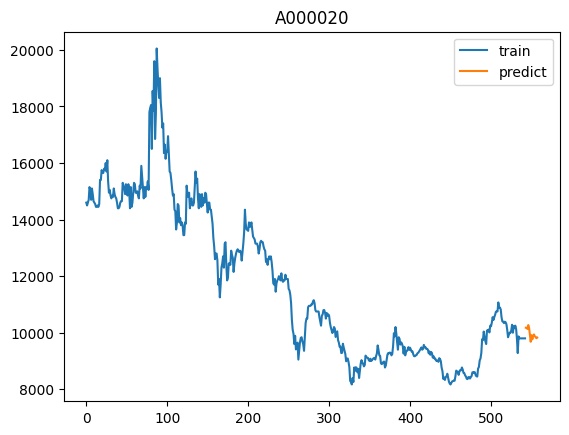

In [24]:
plt.plot(range(0, 543), np.array(train.loc[train['item_Code'] == 'A000020', 'Close']), label = 'train')
plt.plot(range(543, 558), model_predictions[0], label = 'predict')
plt.title(f'A000020')
plt.legend()
plt.show()

In [ ]:
|step_size = 15
linear_predictions = []
item_Code_list = train.item_Code.unique().tolist()

for n, item_Code in enumerate(train['item_Code'].unique().tolist()):

  print('-' * 20)
  print(f'count: {n}, item_Code: {item_Code}')
  print('-' * 20)

  item_set = train[train['item_Code'] == item_Code]
  item_set = item_set.drop(['Date', 'item_Code', 'item_Name', 'ARIMA_close'], axis = 1)

  print('Before feature importances', item_set.shape)

  # if item_Code in zero_item_Code:
  #   print(f'{item_Code} is zero')
  #   stacked_vae_filter_data.append(torch.Tensor(item_set['Close2'].values))
  #   continue

  #item_set = item_set.astype(float)
  item_set = item_set.fillna(method = 'ffill')
  item_set = item_set.fillna(method = 'bfill')
  print(item_set.isnull().sum()[item_set.isnull().sum() > 0])
  columns_list = item_set.columns.tolist()

  # scaling
  #scaler = StandardScaler()
  #scaler = RobustScaler()
  #scaler = MinMaxScaler(feature_range = (0, 1))
  #scaler = scaler.fit(item_set.drop(['Close2'], axis = 1))
  #item_set_scaled = scaler.transform(item_set.drop(['Close2'], axis = 1))
  #print(item_set_scaled.shape, item_set['Close2'].shape)
  #item_set_scaled = np.hstack((item_set_scaled, np.array(item_set['Close2']).reshape(-1, 1)))
  #item_set_scaled_df = pd.DataFrame(item_set_scaled, columns = columns_list)

  (X_train_fi, y_train_fi), (X_test_fi, y_test_fi) = train_test_split(item_set, 'Close2')
  regressor = xgb.XGBRegressor()
  regressor = regressor.fit(X_train_fi, y_train_fi, eval_set = [(X_train_fi, y_train_fi), (X_test_fi, y_test_fi)], verbose = False)

  fi = X_train_fi.columns[np.array(regressor.feature_importances_) > 0.0].tolist()
  fi.append('Close2')
  #print('len:', len(fi))

  item_set = train[train['item_Code'] == item_Code]
  item_set = item_set[list(set(fi))]

  print('after feature importances', item_set.shape)

  item_set = item_set.astype(float)
  item_set = item_set.fillna(method = 'ffill')
  item_set = item_set.fillna(method = 'bfill')
  print(item_set.isnull().sum()[item_set.isnull().sum() > 0])

  X = item_set.drop(['Close2'], axis = 1)
  y = item_set['Close2']

  if item_set.shape[1] < 2:

    print(f'{item_Code} is zero')

    y_test = y[-step_size:]
    test_pred = y_test
    linear_predictions.append(test_pred)

  else:
    X_train = X[:-2*step_size]
    X_validation = X[-2*step_size:-step_size]
    X_test = X[-step_size:]

    #scaler = MinMaxScaler(feature_range = (0, 1))
    #y = scaler.fit_transform(y.reshape(-1, 1))

    y_train = y[:-2*step_size]
    y_validation = y[-2*step_size:-step_size]
    y_test = y[-step_size:]

    model = lm.LinearRegression()
    model.fit(X_train, y_train)
    val_pred = model.predict(X_validation)

    print(MAE(val_pred, y_validation))
    print(MAPE(val_pred, y_validation))
    print(RMSE(val_pred, y_validation))

    model.fit(pd.concat([X_train, X_validation], axis = 0), pd.concat([y_train, y_validation], axis = 0))
    test_pred = model.predict(X_test)
    #test_pred = scaler.inverse_transform(test_pred)
    linear_predictions.append(test_pred)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
--------------------
count: 1499, item_Code: A153490
--------------------
Before feature importances (494, 128)
Series([], dtype: int64)
after feature importances (494, 108)
Series([], dtype: int64)
0.012387842605357946
0.0010546620043890061
0.015224531158486909
--------------------
count: 1500, item_Code: A153710
--------------------
Before feature importances (494, 128)
Series([], dtype: int64)
after feature importances (494, 111)
Series([], dtype: int64)
0.02260397415187375
0.0002824034967012696
0.02479565824112596
--------------------
count: 1501, item_Code: A155650
--------------------
Before feature importances (494, 128)
Series([], dtype: int64)
after feature importances (494, 112)
Series([], dtype: int64)
0.0027402558909064584
4.2500542472530054e-05
0.0031958866297720195
--------------------
count: 1502, item_Code: A155660
--------------------
Before feature importances (494, 128)
Series([], dtype: int64)
after feature importances (494, 108)


In [ ]:
np.array(linear_predictions).shape

(2000, 15)

In [ ]:
returns_dailys = []
for i in range(0, 2000):
  linear_prediction = linear_predictions[i].tolist()
  returns_daily = (linear_prediction[-1] - linear_prediction[0]) / linear_prediction[0]
  returns_dailys.append(returns_daily)

In [ ]:
np.array(returns_dailys).shape

(2000,)

In [29]:
item_Code_list = train.item_Code.unique().tolist()
results_df = pd.DataFrame(columns = ['종목코드', '순위'])
for idx, item_Code in tqdm(enumerate(item_Code_list)):
  results_df = results_df.append({'종목코드': item_Code, 'final_return': np.array(returns_dailys[idx], dtype = float)}, ignore_index = True)

2000it [00:06, 294.03it/s]


In [30]:
results_df

,종목코드,순위,final_return
0,A000020,NaN,-0.034362372010946274
1,A000040,NaN,-0.06921963393688202
2,A000050,NaN,-0.01869654469192028
3,A000070,NaN,-0.025315672159194946
4,A000080,NaN,-0.03829531371593475
...,...,...,...
1995,A375500,NaN,0.0
1996,A378850,NaN,-0.055992692708969116
1997,A383220,NaN,0.0
1998,A383310,NaN,0.36611562967300415


In [31]:
sample_submission['순위'] = results_df['final_return'].rank(method = 'first', ascending = False).astype(int)
sample_submission

,종목코드,순위
0,A000020,872
1,A000040,1352
2,A000050,674
3,A000070,752
4,A000080,923
...,...,...
1995,A375500,497
1996,A378850,1169
1997,A383220,498
1998,A383310,17


In [ ]:
def calculate_sharpe_ratio(returns):
  returns = np.array(returns)
  risk_free_rate = 0.035
  trading_days_per_year = 252
  excess_returns = returns - risk_free_rate
  annualized_return = np.mean(returns) * trading_days_per_year
  annualized_volatility = np.std(returns) * np.sqrt(trading_days_per_year)
  sharpe_ratio = annualized_return / annualized_volatility
  return sharpe_ratio

In [ ]:
sharpe_ratios = []
for returns in model_predictions:
  sharpe_ratio = calculate_sharpe_ratio(returns)
  sharpe_ratios.append(sharpe_ratio)

In [ ]:
# def annualized_total_assets_final_return_process(closing_price, number_of_trading_days):
#   closing_price = np.array(closing_price) # 배열 처리를 위해 변환
#   final_buy_yields = np.zeros((2000, ))
#   final_short_selling_yields = np.zeros((2000, ))

#   for n in range(1, number_of_trading_days):

#     # 마지막 거래일의 종가
#     closing_price_last_trading_day = closing_price[:, n]

#     # 첫번째 거래일의 종가
#     closing_price_first_trading_day = closing_price[:, 0]

#     # 최종 매수 수익률
#     final_buy_yield = (closing_price_last_trading_day - closing_price_first_trading_day) / closing_price_first_trading_day

#     # 최종 공매도 수익률
#     final_short_selling_yield = ((closing_price_last_trading_day - closing_price_first_trading_day) / closing_price_first_trading_day) * (-1)

#     # 200주에 대한 최종 매수 수익률과 공매도 수익률의 총합 계산
#     final_buy_yields += final_buy_yield
#     final_short_selling_yields += final_short_selling_yield

#   total_final_buy_yield = np.sum(final_buy_yields[:200])
#   total_final_short_selling_yield = np.sum(final_short_selling_yields[-200:])

#   # 총자산 최종 수익률
#   total_assets_final_return = (total_final_buy_yield + total_final_short_selling_yield) / 400

#   # 연율화된 총자산 최종 수익률
#   annualized_total_assets_final_return = total_assets_final_return * (250 / number_of_trading_days)

#   return annualized_total_assets_final_return

In [33]:
def annualized_total_assets_final_return_process(closing_price, number_of_trading_days):
  closing_price = np.array(closing_price) # 배열 처리를 위해 변환

  # 마지막 거래일의 종가
  closing_price_last_trading_day = closing_price[:, number_of_trading_days-1]

  # 첫번째 거래일의 종가
  closing_price_first_trading_day = closing_price[:, 0]

  # 최종 매수 수익률
  final_buy_yield = (closing_price_last_trading_day - closing_price_first_trading_day) / closing_price_first_trading_day

  # 최종 공매도 수익률
  final_short_selling_yield = ((closing_price_last_trading_day - closing_price_first_trading_day) / closing_price_first_trading_day) * (-1)

  total_final_buy_yield = np.sum(final_buy_yield[:200])
  total_final_short_selling_yield = np.sum(final_short_selling_yield[-200:])

  # 총자산 최종 수익률
  total_assets_final_return = (total_final_buy_yield + total_final_short_selling_yield) / 400

  # 연율화된 총자산 최종 수익률
  annualized_total_assets_final_return = total_assets_final_return * (250 / number_of_trading_days)

  return annualized_total_assets_final_return

In [34]:
def total_assets_daily_return_volatility_process(closing_price, number_of_trading_days):
  closing_price = np.array(closing_price)
  daily_buy_yields = []
  daily_short_selling_yields = []
  total_assets_daily_return_volatility = 0
  ns = []
  annualized_daliy_returns = []
  daliy_returns = []

  for n in range(3, number_of_trading_days):

    # 현시점 거래일의 종가
    closing_price_current_trading_day = closing_price[:, n]

    # 전날 거래일의 종가
    closing_price_previous_trading_day = closing_price[:, n-1]

    # 일간 매수일의 수익률
    daily_buy_yield = (closing_price_current_trading_day - closing_price_previous_trading_day) / closing_price_previous_trading_day
    daily_short_selling_yield = ((closing_price_current_trading_day - closing_price_previous_trading_day) / closing_price_previous_trading_day) * (-1)

    # 연율화된 일간 수익률
    annualized_daliy_return = (daily_buy_yield[:200] + daily_short_selling_yield[-200:]) * 250
    daliy_return = (daily_buy_yield[:200] + daily_short_selling_yield[-200:])
    annualized_daliy_returns.append(annualized_daliy_return)
    daliy_returns.append(daliy_return)

  # 총자산 일간 수익률 변동성
  for n in range(3, number_of_trading_days):
    temp = (np.mean(annualized_daliy_returns[n-3]) - np.mean(daliy_returns[n-3])) ** 2
    total_assets_daily_return_volatility += temp / (n - 2)

  return np.sqrt(total_assets_daily_return_volatility)

In [35]:
def public_evaluation_process(closing_price, number_of_trading_days):

  # 연율화된 총자산 최종 수익률
  annualized_total_assets_final_return = annualized_total_assets_final_return_process(closing_price, number_of_trading_days)

  # 무위험 수익률
  risk_free_rate_of_return = 3.5 / 100

  # 총자산 일간 수익률 변동성
  total_assets_daily_return_volatility = total_assets_daily_return_volatility_process(closing_price, number_of_trading_days)

  # 샤프지수
  sharp_index = (annualized_total_assets_final_return - risk_free_rate_of_return) / total_assets_daily_return_volatility
  return sharp_index

In [36]:
public_evaluation_process(model_predictions, 15) # 0.24 -> lstm_final, 0.102 -> bilstm

-0.001551673256821365

In [37]:
sample_submission.to_csv('./final_private.csv', index = False)

In [38]:
sample_submission

,종목코드,순위
0,A000020,872
1,A000040,1352
2,A000050,674
3,A000070,752
4,A000080,923
...,...,...
1995,A375500,497
1996,A378850,1169
1997,A383220,498
1998,A383310,17


In [243]:
sample_submission = pd.read_csv('/content/bilstm_final_private_50_mac.csv')

In [244]:
sample_submission

,종목코드,순위
0,A000020,1014
1,A000040,1725
2,A000050,548
3,A000070,320
4,A000080,713
...,...,...
1995,A375500,732
1996,A378850,1296
1997,A383220,1879
1998,A383310,53


In [245]:
model_predictions = np.load('/content/model_predictions_bilstm_fianl_private_50_mac.npy')

In [246]:
model_predictions

array([[ 10010.667  ,  10009.822  ,   9920.27   , ...,   8183.0205 ,
          9549.287  ,   9544.381  ],
       [   532.0176 ,    522.02734,    516.47894, ...,    476.06537,
           473.05383,    475.1204 ],
       [  9636.607  ,   9621.921  ,   9642.411  , ...,   9632.15   ,
          9555.326  ,   9578.632  ],
       ...,
       [114324.53   ,  97795.875  , 110919.59   , ...,  97795.875  ,
        100297.     ,  97896.36   ],
       [ 66626.805  ,  78827.22   ,  87130.555  , ...,  86790.83   ,
         85808.13   ,  85627.99   ],
       [  8004.335  ,   7980.1475 ,   7968.4937 , ...,   8285.26   ,
          8244.689  ,   8245.701  ]], dtype=float32)

In [247]:
model_predictions

array([[ 10010.667  ,  10009.822  ,   9920.27   , ...,   8183.0205 ,
          9549.287  ,   9544.381  ],
       [   532.0176 ,    522.02734,    516.47894, ...,    476.06537,
           473.05383,    475.1204 ],
       [  9636.607  ,   9621.921  ,   9642.411  , ...,   9632.15   ,
          9555.326  ,   9578.632  ],
       ...,
       [114324.53   ,  97795.875  , 110919.59   , ...,  97795.875  ,
        100297.     ,  97896.36   ],
       [ 66626.805  ,  78827.22   ,  87130.555  , ...,  86790.83   ,
         85808.13   ,  85627.99   ],
       [  8004.335  ,   7980.1475 ,   7968.4937 , ...,   8285.26   ,
          8244.689  ,   8245.701  ]], dtype=float32)

In [248]:
sample_submission['Close'] = list(model_predictions)

In [249]:
sample_submission

,종목코드,순위,Close
0,A000020,1014,"[10010.667, 10009.822, 9920.27, 9931.122, 9905..."
1,A000040,1725,"[532.0176, 522.02734, 516.47894, 508.62018, 50..."
2,A000050,548,"[9636.607, 9621.921, 9642.411, 9647.43, 9643.7..."
3,A000070,320,"[68052.26, 70686.41, 70564.16, 70676.33, 70461..."
4,A000080,713,"[20946.152, 20663.934, 20565.465, 19283.93, 20..."
...,...,...,...
1995,A375500,732,"[31966.734, 31867.459, 31718.16, 31652.498, 31..."
1996,A378850,1296,"[4495.556, 4382.273, 4340.7783, 4271.64, 4216...."
1997,A383220,1879,"[114324.53, 97795.875, 110919.59, 97795.875, 1..."
1998,A383310,53,"[66626.805, 78827.22, 87130.555, 34872.277, 95..."


In [250]:
sample_submission_copy = sample_submission.copy()
sample_submission_copy = sample_submission_copy.drop(['순위'], axis = 1)

In [251]:
cc_close = sample_submission_copy.groupby(['종목코드'])['Close'].apply(list).to_dict()

In [252]:
cc_close = {key: value[0] for key, value in cc_close.items()}

In [257]:
cc_rank = sample_submission.sort_values(['순위'])['종목코드'].tolist()

np_cc_buy = np.array([ cc_close[cc] for cc in cc_rank[:200] ])
np_cc_sell = np.array([ cc_close[cc] for cc in cc_rank[-200:] ])

assert np_cc_buy.shape[1] == 15

value = {}
value['매매일수'] = 15
value['무위험수익률'] = 0.035
value['총 매수 수익률'] = +np.sum(((np_cc_buy[:,-1] - np_cc_buy[:, 0]) / np_cc_buy[:, 0]))#= + np.sum( np_cc_buy [:,-1]/np_cc_buy [:,0]-1.0 )
value['총 공매도 수익률'] = +np.sum(((np_cc_sell[:,-1] - np_cc_sell[:, 0]) / np_cc_sell[:, 0]) * -1)#= - np.sum( np_cc_sell[:,-1]/np_cc_sell[:,0]-1.0 )
value['총 자산 최종 수익률'] = ( value['총 매수 수익률'] + value['총 공매도 수익률'] ) / 400
value['연율화된 총자산 최종 수익률'] = value['총 자산 최종 수익률'] * 250 / value['매매일수']

profit_day_buy = + ( np_cc_buy [:,1:]/np_cc_buy [:,:-1]-1.0 )
profit_day_sell = - ( np_cc_sell[:,1:]/np_cc_sell[:,:-1]-1.0 )

value['연율화된 일간수익률의 일별 평균'] = ( profit_day_buy + profit_day_sell ).sum(0) * 250 / 400
value['연율화된 일간수익률의 평균'] = np.mean(value['연율화된 일간수익률의 일별 평균'])
value['총자산 일간 수익률 변동성'] = ( np.sum( ( value['연율화된 일간수익률의 일별 평균'] - value['연율화된 일간수익률의 평균'] ) ** 2.0 ) / (15-2) ) ** 0.5
value['샤프지수'] = ( value['연율화된 총자산 최종 수익률'] - value['무위험수익률'] ) / value['총자산 일간 수익률 변동성']

print('총자산 일간 수익률 변동성(다른계산법들)',
   value['연율화된 일간수익률의 일별 평균'].std() * np.sqrt(14/13),
   np.concatenate( ( profit_day_buy, profit_day_sell ) ).mean(0).std() * np.sqrt(14/13) * 250
   )

총자산 일간 수익률 변동성(다른계산법들) 12.55082379310271 12.550820476146402


In [258]:
value

{'매매일수': 15,
 '무위험수익률': 0.035,
 '총 매수 수익률': 80.85518,
 '총 공매도 수익률': 39.940994,
 '총 자산 최종 수익률': 0.3019904327392578,
 '연율화된 총자산 최종 수익률': 5.03317387898763,
 '연율화된 일간수익률의 일별 평균': array([28.543146 ,  2.4315226,  4.6961284,  4.426783 , 35.893715 ,
         4.5735226,  3.9092872,  1.9318991, 25.856997 ,  4.316855 ,
        -0.7135781, -4.343806 ,  7.8151746, -4.9374137], dtype=float32),
 '연율화된 일간수익률의 평균': 8.171446,
 '총자산 일간 수익률 변동성': 12.55082366139079,
 '샤프지수': 0.3982347305510441}

private 50 mac - {'매매일수': 15,
 '무위험수익률': 0.035,
 '총 매수 수익률': 80.85519,
 '총 공매도 수익률': 39.94099,
 '총 자산 최종 수익률': 0.3019904327392578,
 '연율화된 총자산 최종 수익률': 5.03317387898763,
 '연율화된 일간수익률의 일별 평균': array([28.543146 ,  2.4315226,  4.6961284,  4.426783 , 35.893715 ,
         4.5735226,  3.9092872,  1.9318991, 25.856997 ,  4.316855 ,
        -0.7135781, -4.343806 ,  7.8151746, -4.9374137], dtype=float32),
 '연율화된 일간수익률의 평균': 8.171446,
 '총자산 일간 수익률 변동성': 12.55082366139079,
 '샤프지수': 0.3982347305510441}

private_50 - {'매매일수': 15,
 '무위험수익률': 0.035,
 '총 매수 수익률': 39.739315,
 '총 공매도 수익률': 20.54947,
 '총 자산 최종 수익률': 0.1507219696044922,
 '연율화된 총자산 최종 수익률': 2.5120328267415366,
 '연율화된 일간수익률의 일별 평균': array([ -1.3785872,   3.1500013,  -5.108241 ,   4.8850703,  31.683222 ,
          4.7799764,   1.0837826,   3.49767  ,  21.084288 ,   5.2552257,
         -1.9286356,  -4.4341445,   8.721679 , -16.13519  ], dtype=float32),
 '연율화된 일간수익률의 평균': 3.9397233,
 '총자산 일간 수익률 변동성': 11.490873357705956,
 '샤프지수': 0.21556523596010221}

private - {'매매일수': 15,
 '무위험수익률': 0.035,
 '총 매수 수익률': 48.93498,
 '총 공매도 수익률': 34.26474,
 '총 자산 최종 수익률': 0.20799930572509764,
 '연율화된 총자산 최종 수익률': 3.4666550954182944,
 '연율화된 일간수익률의 일별 평균': array([ 5.4506407 ,  4.4643264 ,  4.529664  ,  0.59626263, 17.545414  ,
         5.949546  ,  1.2998953 ,  2.8833265 ,  2.7587273 ,  1.9126161 ,
        -4.782438  ,  0.6964591 ,  0.9037506 ,  5.8440022 ], dtype=float32),
 '연율화된 일간수익률의 평균': 3.5751572,
 '총자산 일간 수익률 변동성': 4.917825906193692,
 '샤프지수': 0.6977992228428299}

bilstm_final - {'매매일수': 15,
 '무위험수익률': 0.035,
 '총 매수 수익률': 140.85645,
 '총 공매도 수익률': 36.04045,
 '총 자산 최종 수익률': 0.4422422409057617,
 '연율화된 총자산 최종 수익률': 7.370704015096028,
 '연율화된 일간수익률의 일별 평균': array([40.572647  , 14.423359  , -3.1744742 , -6.8076286 ,  9.145387  ,
         6.2669497 ,  7.2636857 ,  1.4549137 , -8.12414   ,  5.3880687 ,
         1.6152933 , 18.258434  ,  0.59860605, 16.204739  ], dtype=float32),
 '연율화된 일간수익률의 평균': 7.3632746,
 '총자산 일간 수익률 변동성': 12.475514254107809,
 '샤프지수': 0.5880081466526001}